In [1]:
import sys, os
import torch
import numpy as np 
import pandas as pd
from scDisInFact import scdisinfact, create_scdisinfact_dataset
from scDisInFact import utils

import matplotlib.pyplot as plt

from umap import UMAP
from sklearn.decomposition import PCA
import scipy.sparse as sp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Load the dataset
We used the simulated dataset with $2$ batches and $2$ condition types: 
* groups in type 1: `ctrl`, `stim`
* groups in type 2: `healthy`, `severe`

Totally $8$ count matrices are included (Fig. 2a in the manuscript). We hold out the count matrix corresponding to condition `(ctrl, healthy, batch 0)` for testing purpose, and train scdisinfact on remaining count matrices.

Given the count matrix (list of count matrices where one may correspond to one batch), the meta_cell dataframe (list of dataframe that matches the list of count matrices), and gene names, scDisInFact create training dataset using function `scdisinfact.create_scdisinfact_dataset()`


In [2]:
counts = sp.load_npz("data/demo_data/counts.npz")
meta_cells = pd.read_csv("data/demo_data/meta_cells.csv", index_col = 0)
test_idx = ((meta_cells["condition 1"] == "ctrl") & (meta_cells["condition 2"] == "healthy") & (meta_cells["batch"] == 0)).values
train_idx = ~test_idx

data_dict = create_scdisinfact_dataset(counts[train_idx,:], meta_cells.loc[train_idx,:], condition_key = ["condition 1", "condition 2"], batch_key = "batch")

result_dir = "demo_result/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.


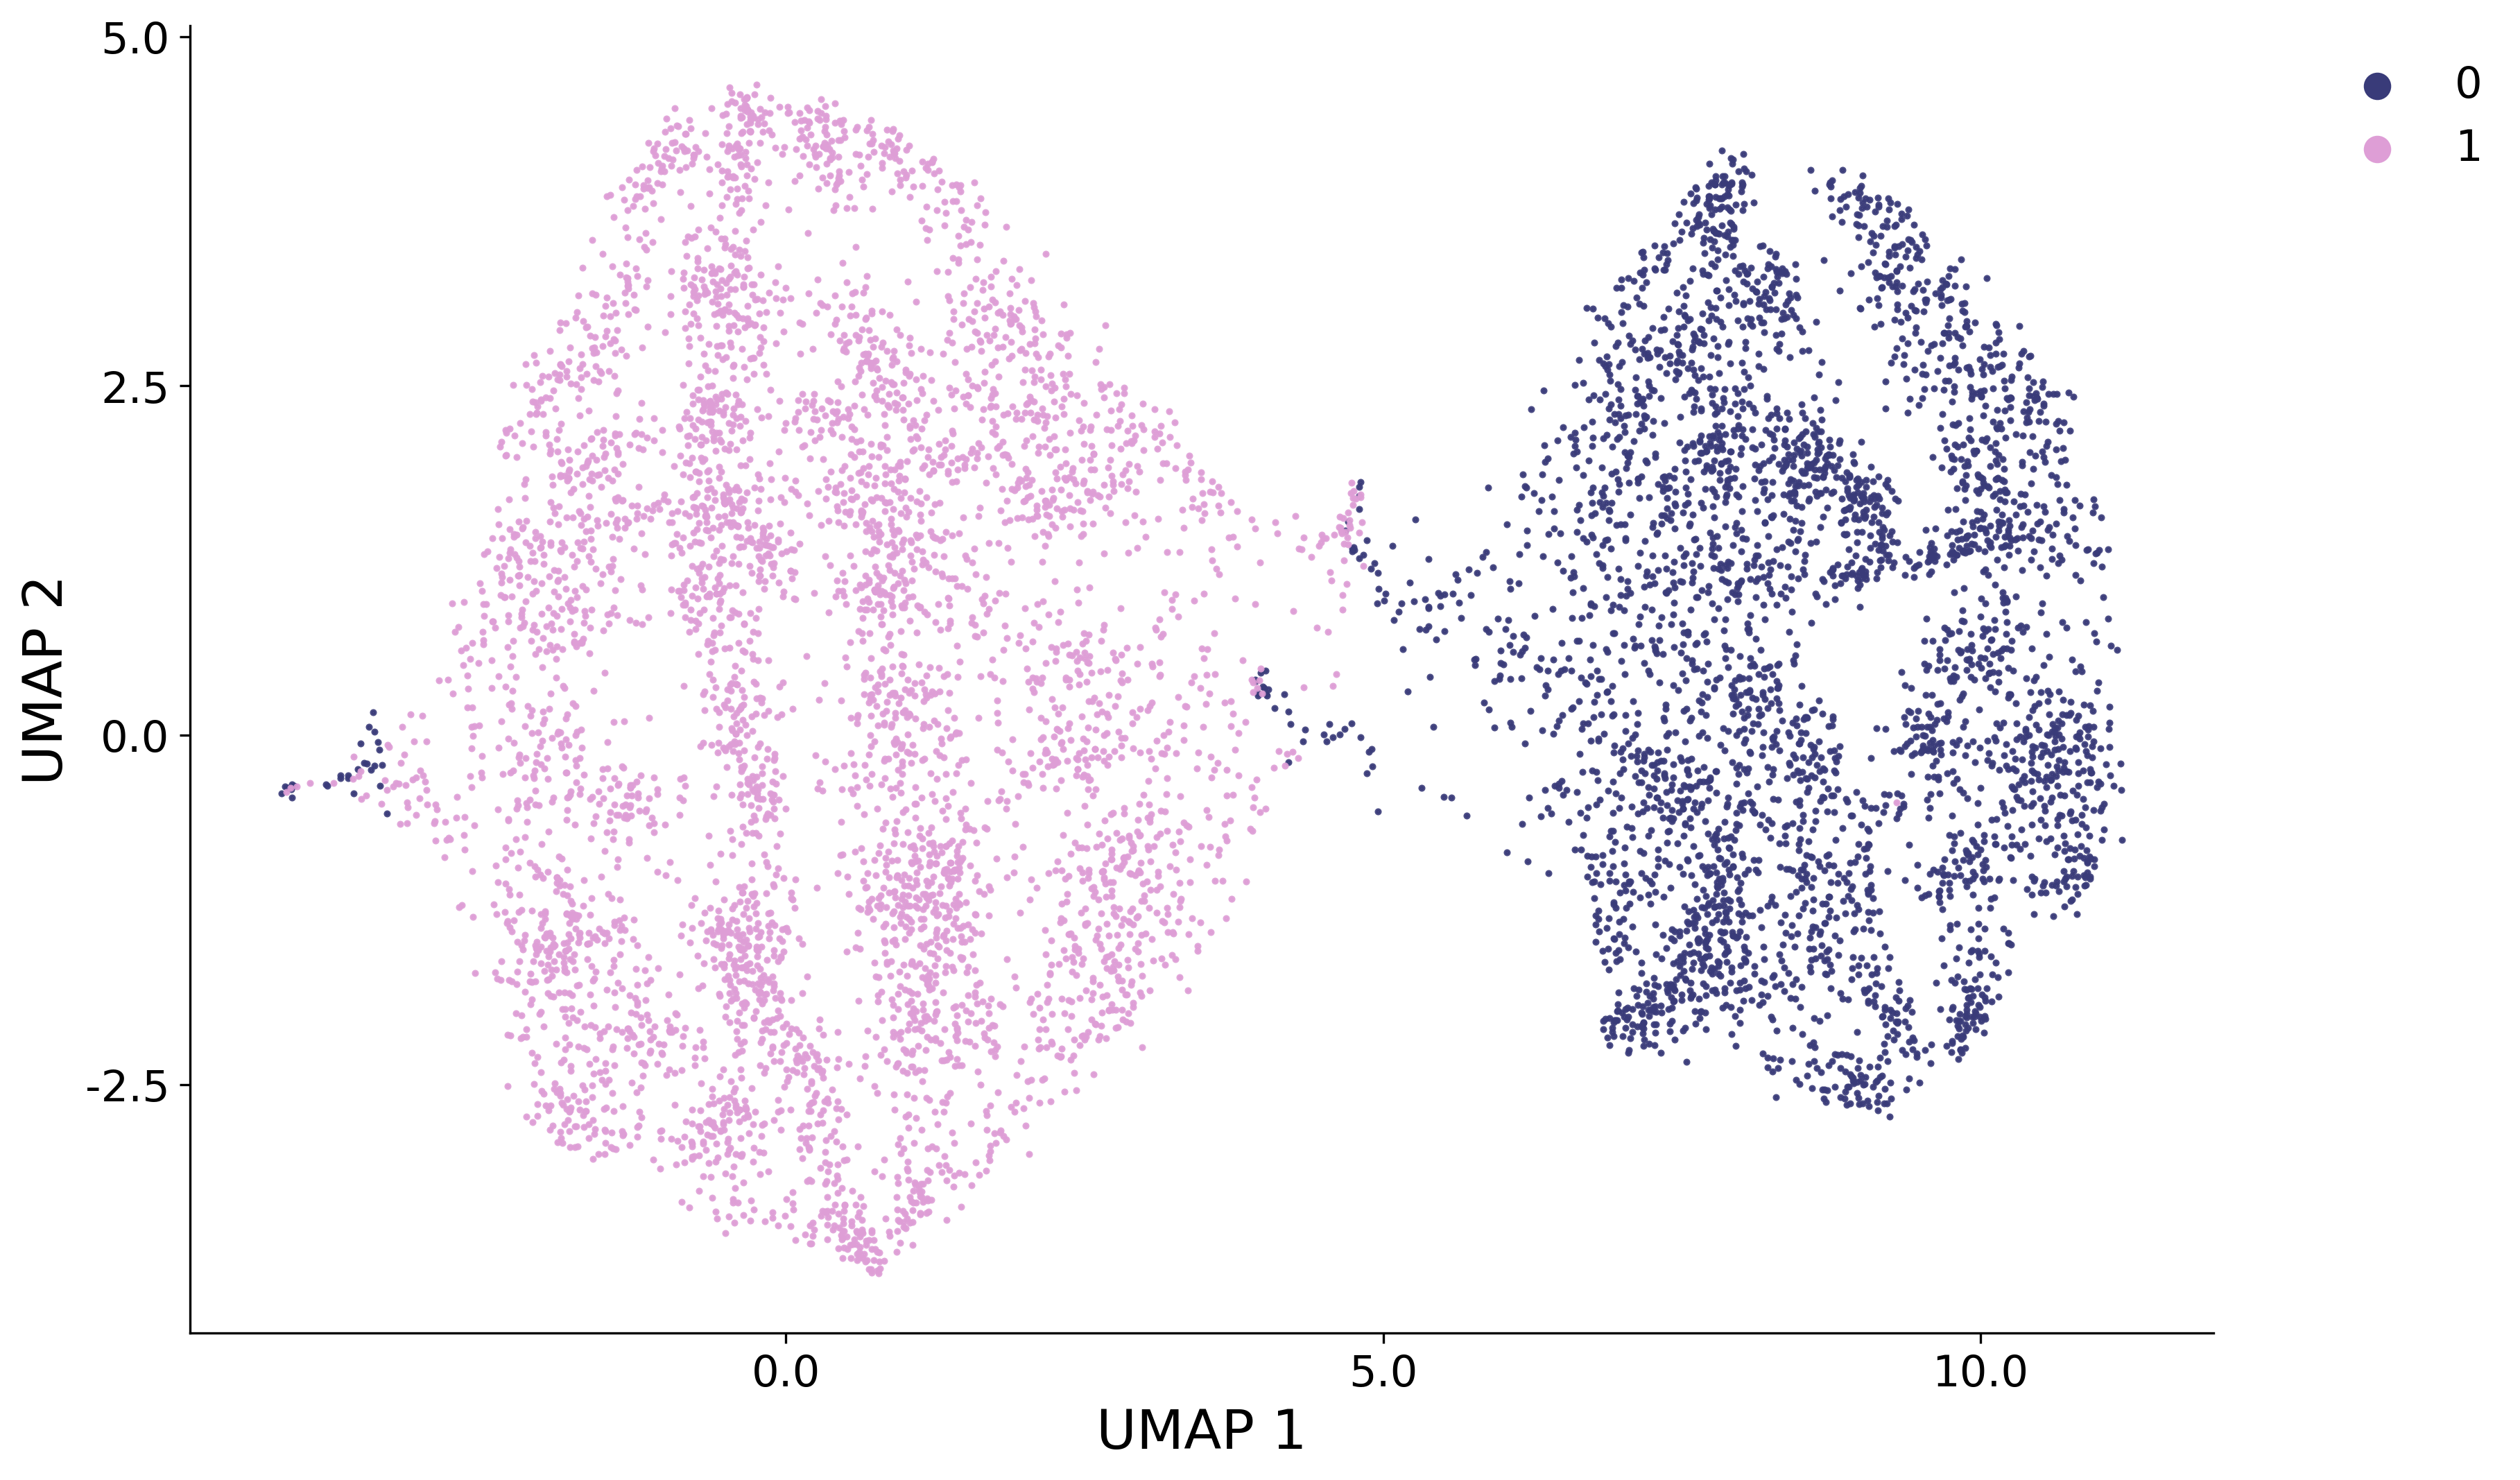

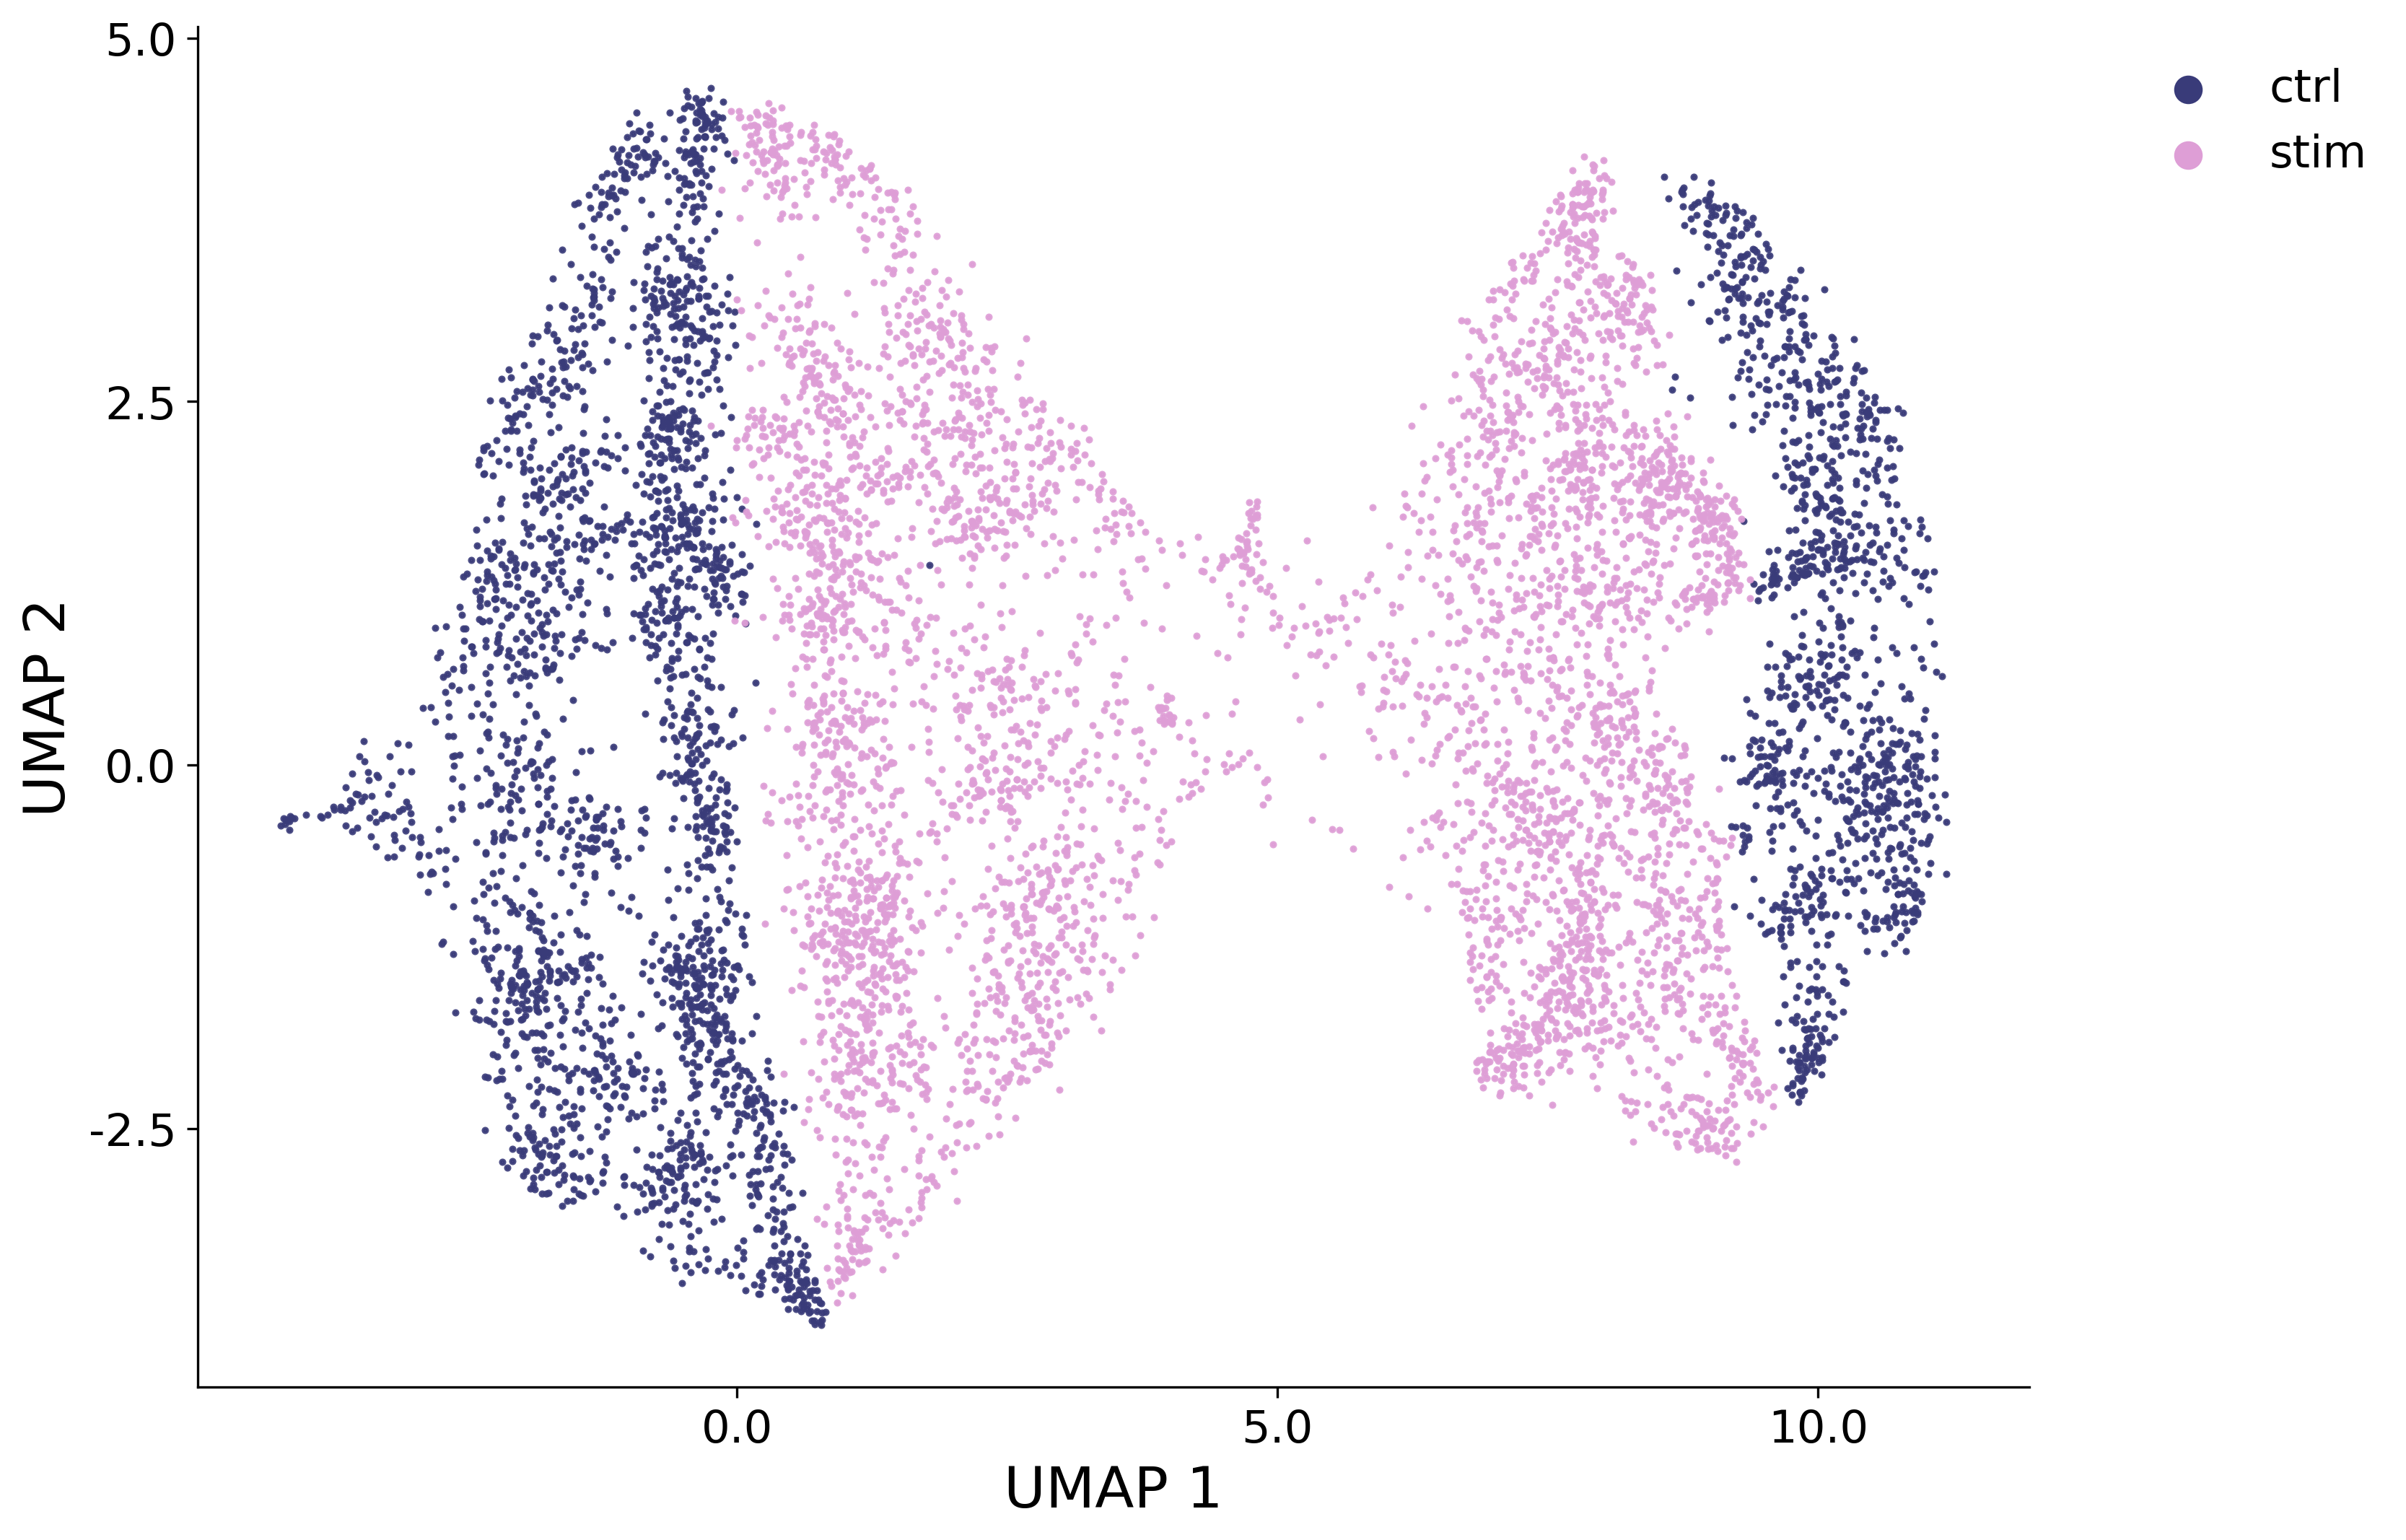

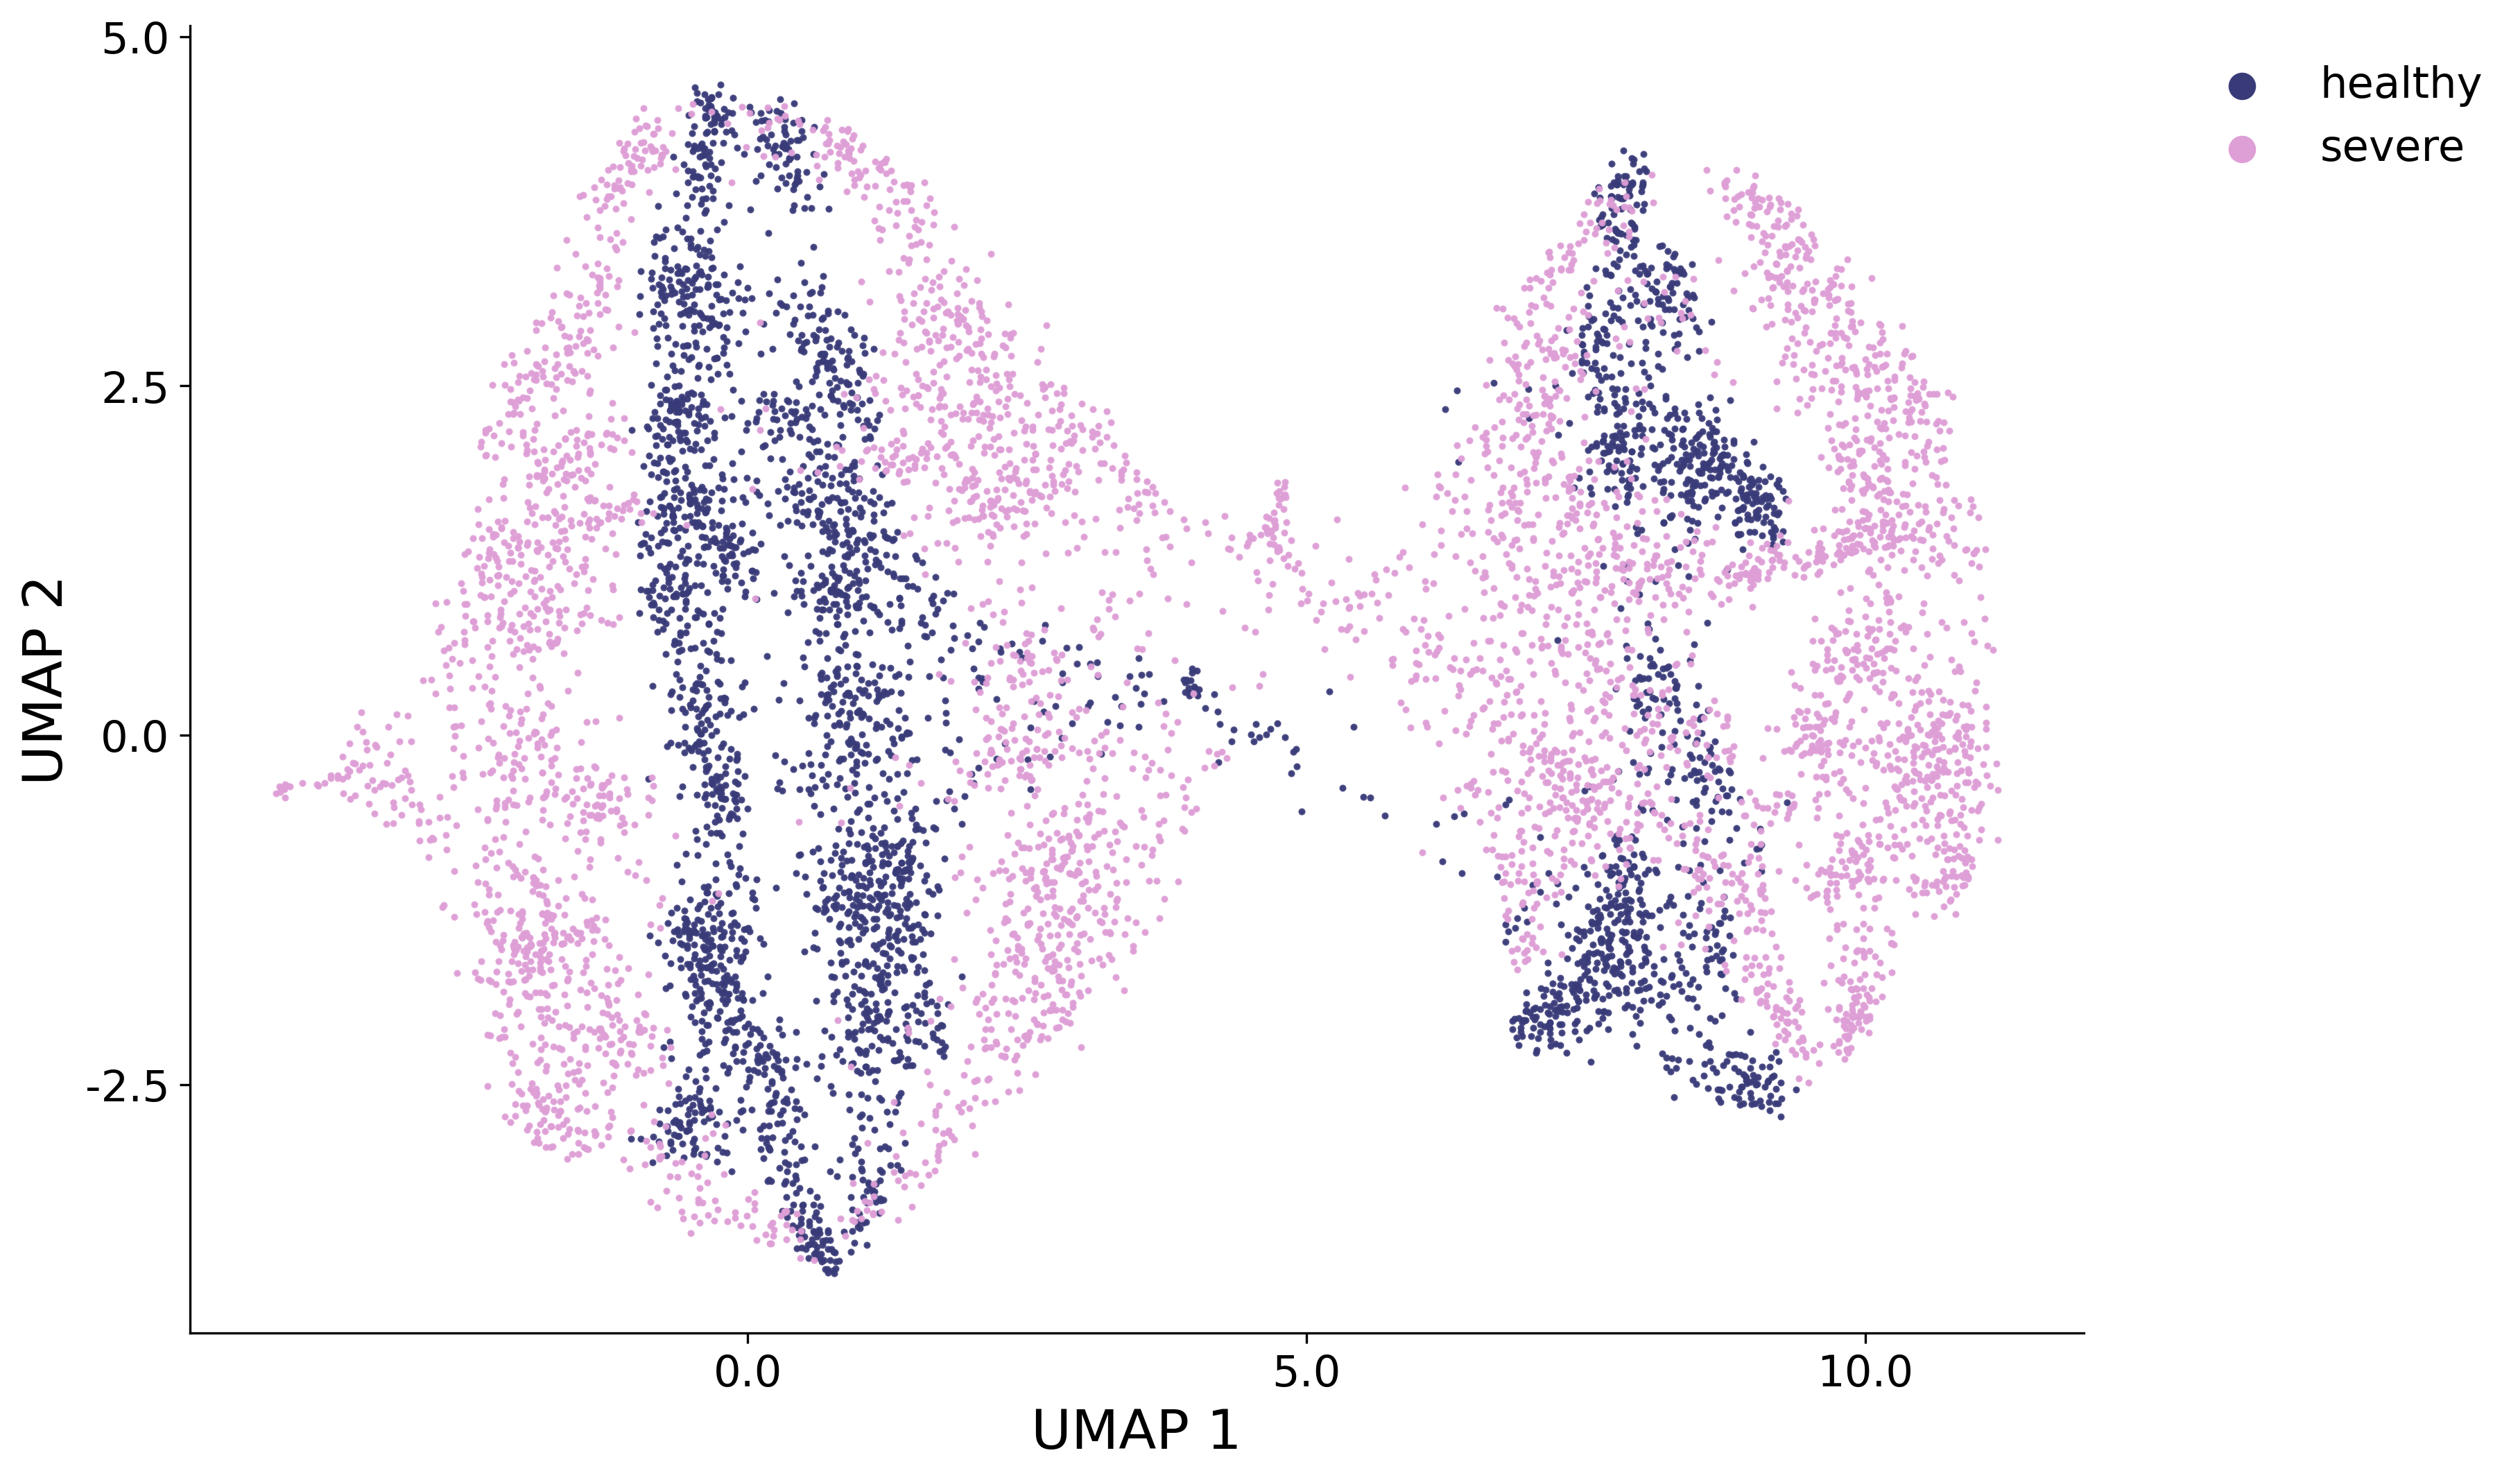

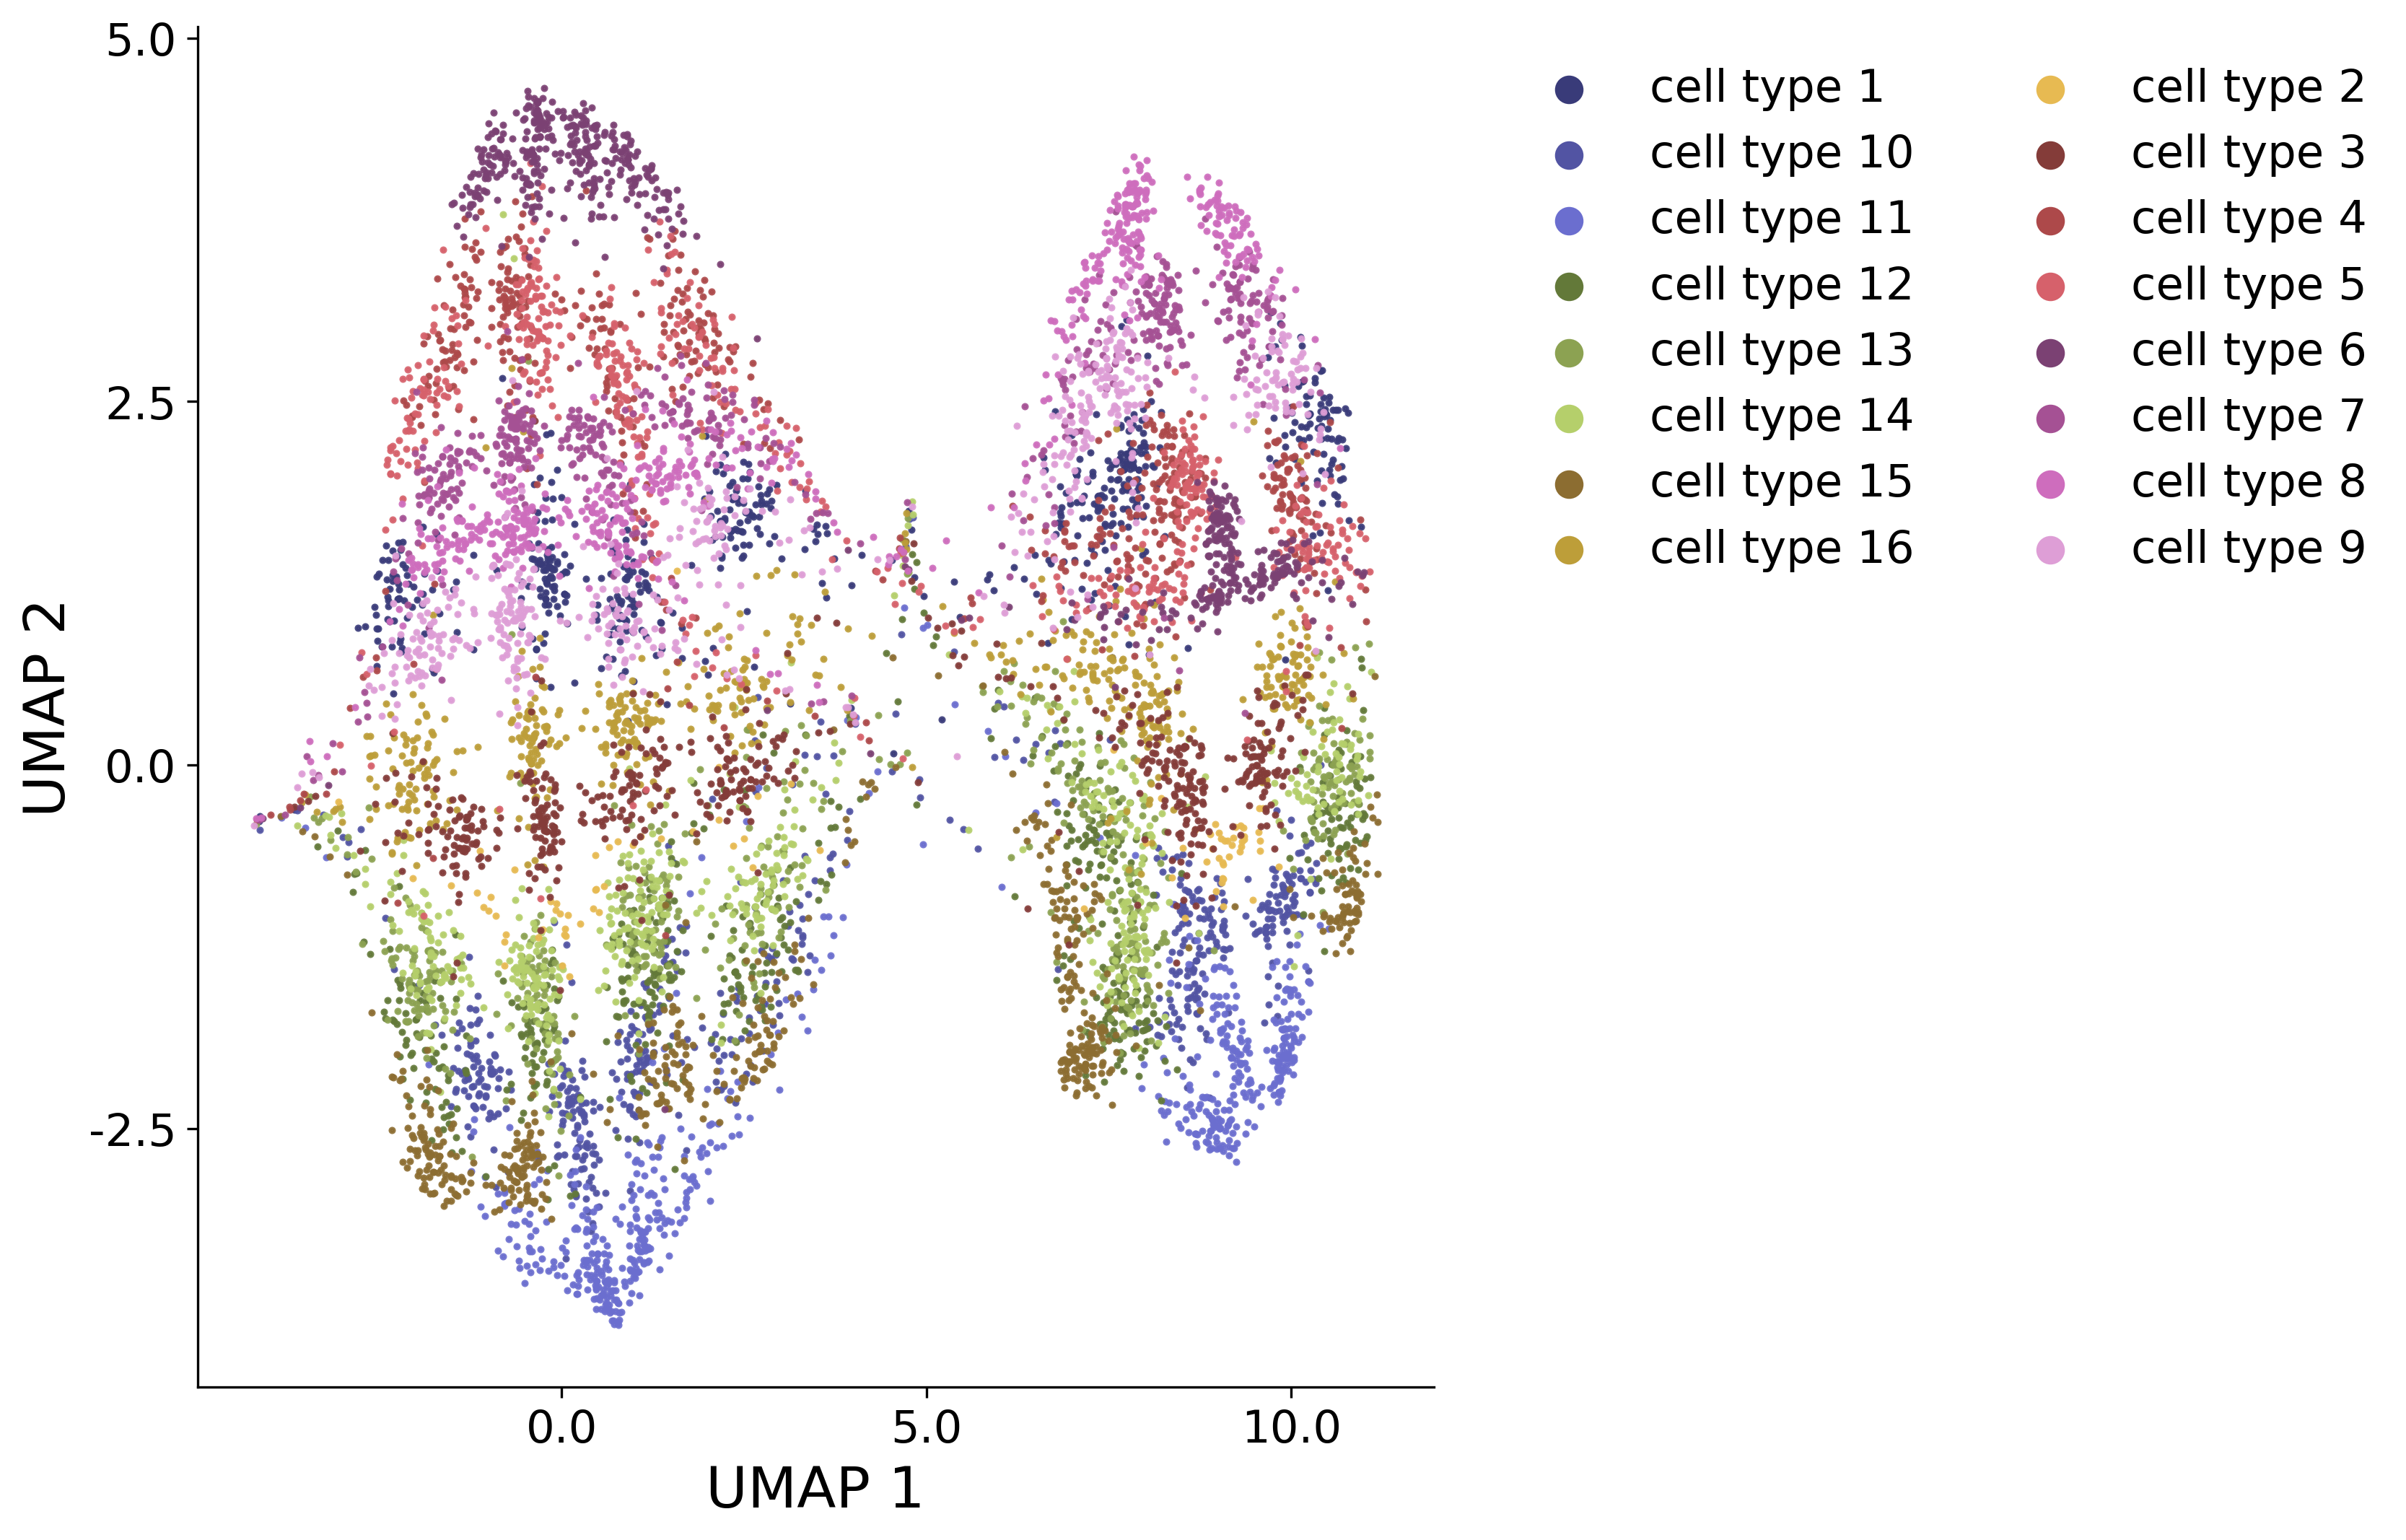

In [3]:
# Visualize the raw gene expression data
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 

x_pca = PCA(n_components = 80).fit_transform(np.concatenate([x.counts_norm for x in data_dict["datasets"]], axis = 0))
x_umap = umap_op.fit_transform(x_pca)

utils.plot_latent(x_umap, annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "batches.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "condition_type_1.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["condition 2"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "condition_type_2.png", figsize = (12,7), axis_label = "UMAP", markerscale = 6, s = 2)

utils.plot_latent(x_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), mode = "annos", save = result_dir + "celltypes.png", figsize = (11,7), axis_label = "UMAP", markerscale = 6, s = 2)


## Training scDisInFact
We use the default hyper-parameter setting

In [6]:
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [8, 2, 2]

batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4
lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]
model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
model.train()
losses = model.train_model(nepochs = nepochs, recon_loss = "NB")
torch.save(model.state_dict(), result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")
model.load_state_dict(torch.load(result_dir + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth", map_location = device))
_ = model.eval()


Epoch 0, Validating Loss: 3.4188
	 loss reconstruction: 2.16931
	 loss kl comm: 2.87213
	 loss kl diff: 4.66035
	 loss mmd common: 3.34361
	 loss mmd diff: 12.10332
	 loss classification: 0.67965
	 loss group lasso diff: 0.52171
GPU memory usage: 25.123047MB
Epoch 10, Validating Loss: 2.0680
	 loss reconstruction: 1.75014
	 loss kl comm: 21.93596
	 loss kl diff: 8.43641
	 loss mmd common: 5.44845
	 loss mmd diff: 2.78692
	 loss classification: 0.06543
	 loss group lasso diff: 0.16700
GPU memory usage: 25.123047MB
Epoch 20, Validating Loss: 1.9584
	 loss reconstruction: 1.71307
	 loss kl comm: 28.37413
	 loss kl diff: 6.75759
	 loss mmd common: 4.50329
	 loss mmd diff: 2.62253
	 loss classification: 0.04067
	 loss group lasso diff: 0.13609
GPU memory usage: 25.123047MB
Epoch 30, Validating Loss: 1.9047
	 loss reconstruction: 1.69450
	 loss kl comm: 34.15609
	 loss kl diff: 5.56363
	 loss mmd common: 3.97935
	 loss mmd diff: 3.38291
	 loss classification: 0.02864
	 loss group lasso diff:

## Visualize shared-bio and unshared-bio factors
After training the model, we extracted the shared-bio and unshared-bio factors from the encoder output.

To conduct forward pass on a test dataset, two functions are needed:
* `model.inference()`: infer the latent factor from the gene expression data (encoder)
* `model.generate()`: generate the gene expression data from the latent factors (decoder)

In [7]:
# one forward pass
z_cs = []
z_ds = []
zs = []

for dataset in data_dict["datasets"]:
    with torch.no_grad():
        # pass through the encoders
        dict_inf = model.inference(counts = dataset.counts_norm.to(model.device), batch_ids = dataset.batch_id[:,None].to(model.device), print_stat = True)
        # pass through the decoder
        dict_gen = model.generative(z_c = dict_inf["mu_c"], z_d = dict_inf["mu_d"], batch_ids = dataset.batch_id[:,None].to(model.device))
        z_c = dict_inf["mu_c"]
        z_d = dict_inf["mu_d"]
        z = torch.cat([z_c] + z_d, dim = 1)
        mu = dict_gen["mu"]    
        z_ds.append([x.cpu().detach().numpy() for x in z_d])
        z_cs.append(z_c.cpu().detach().numpy())
        zs.append(np.concatenate([z_cs[-1]] + z_ds[-1], axis = 1))



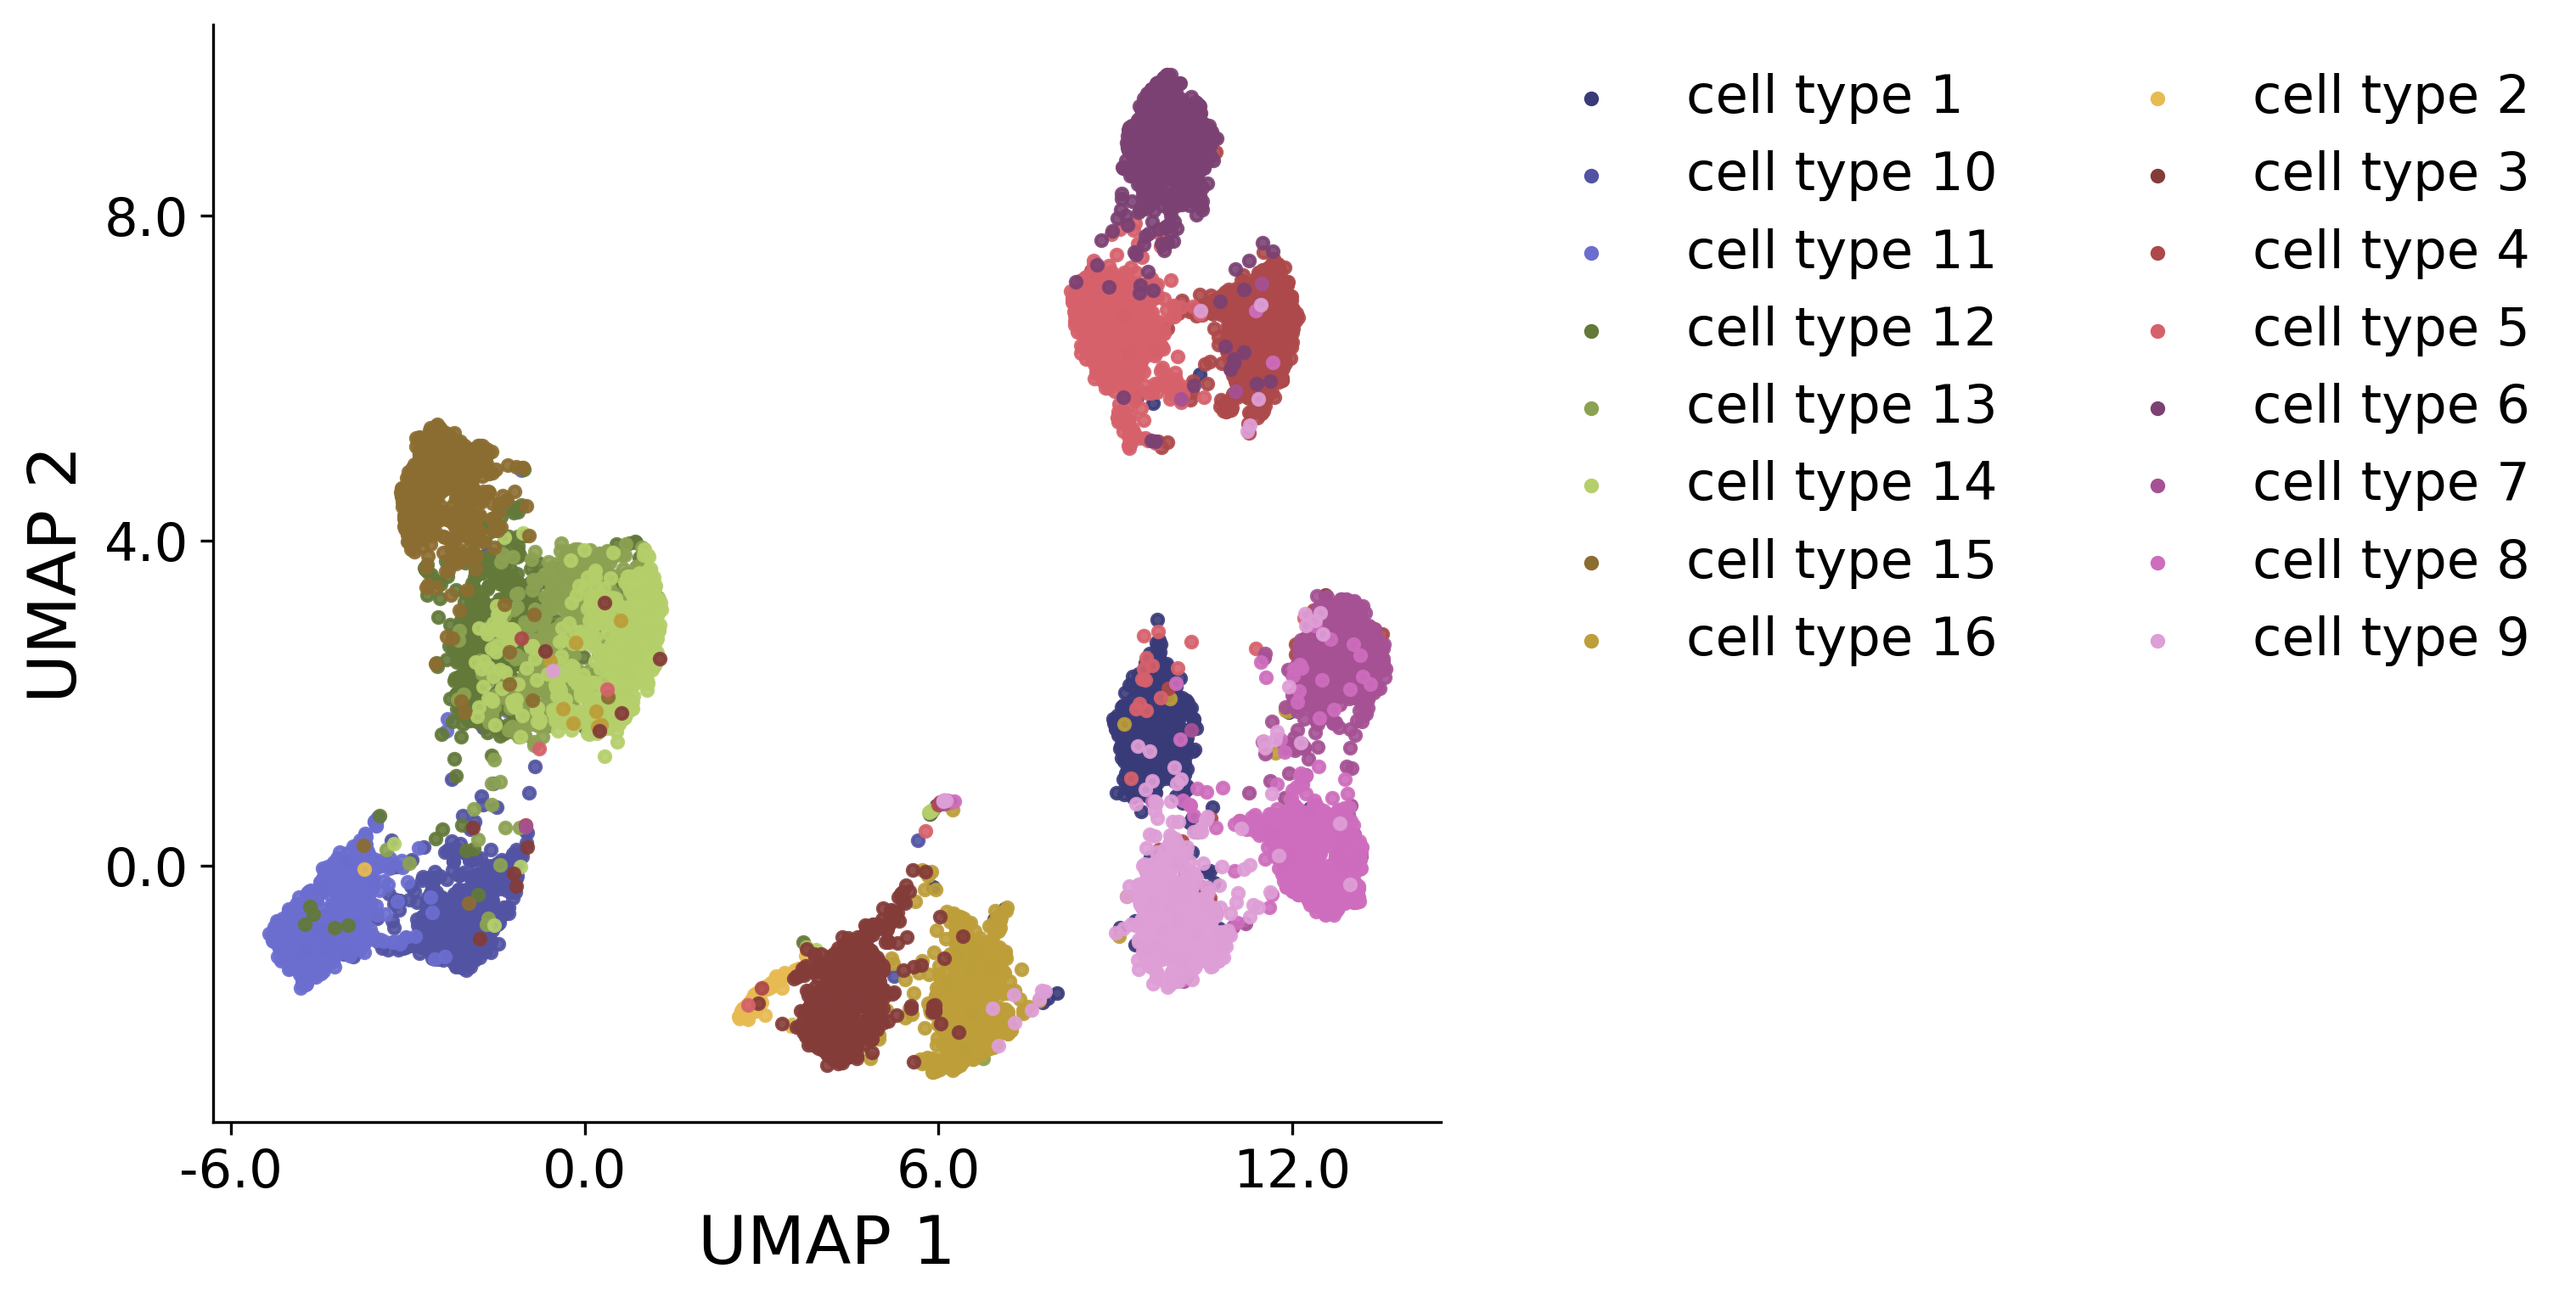

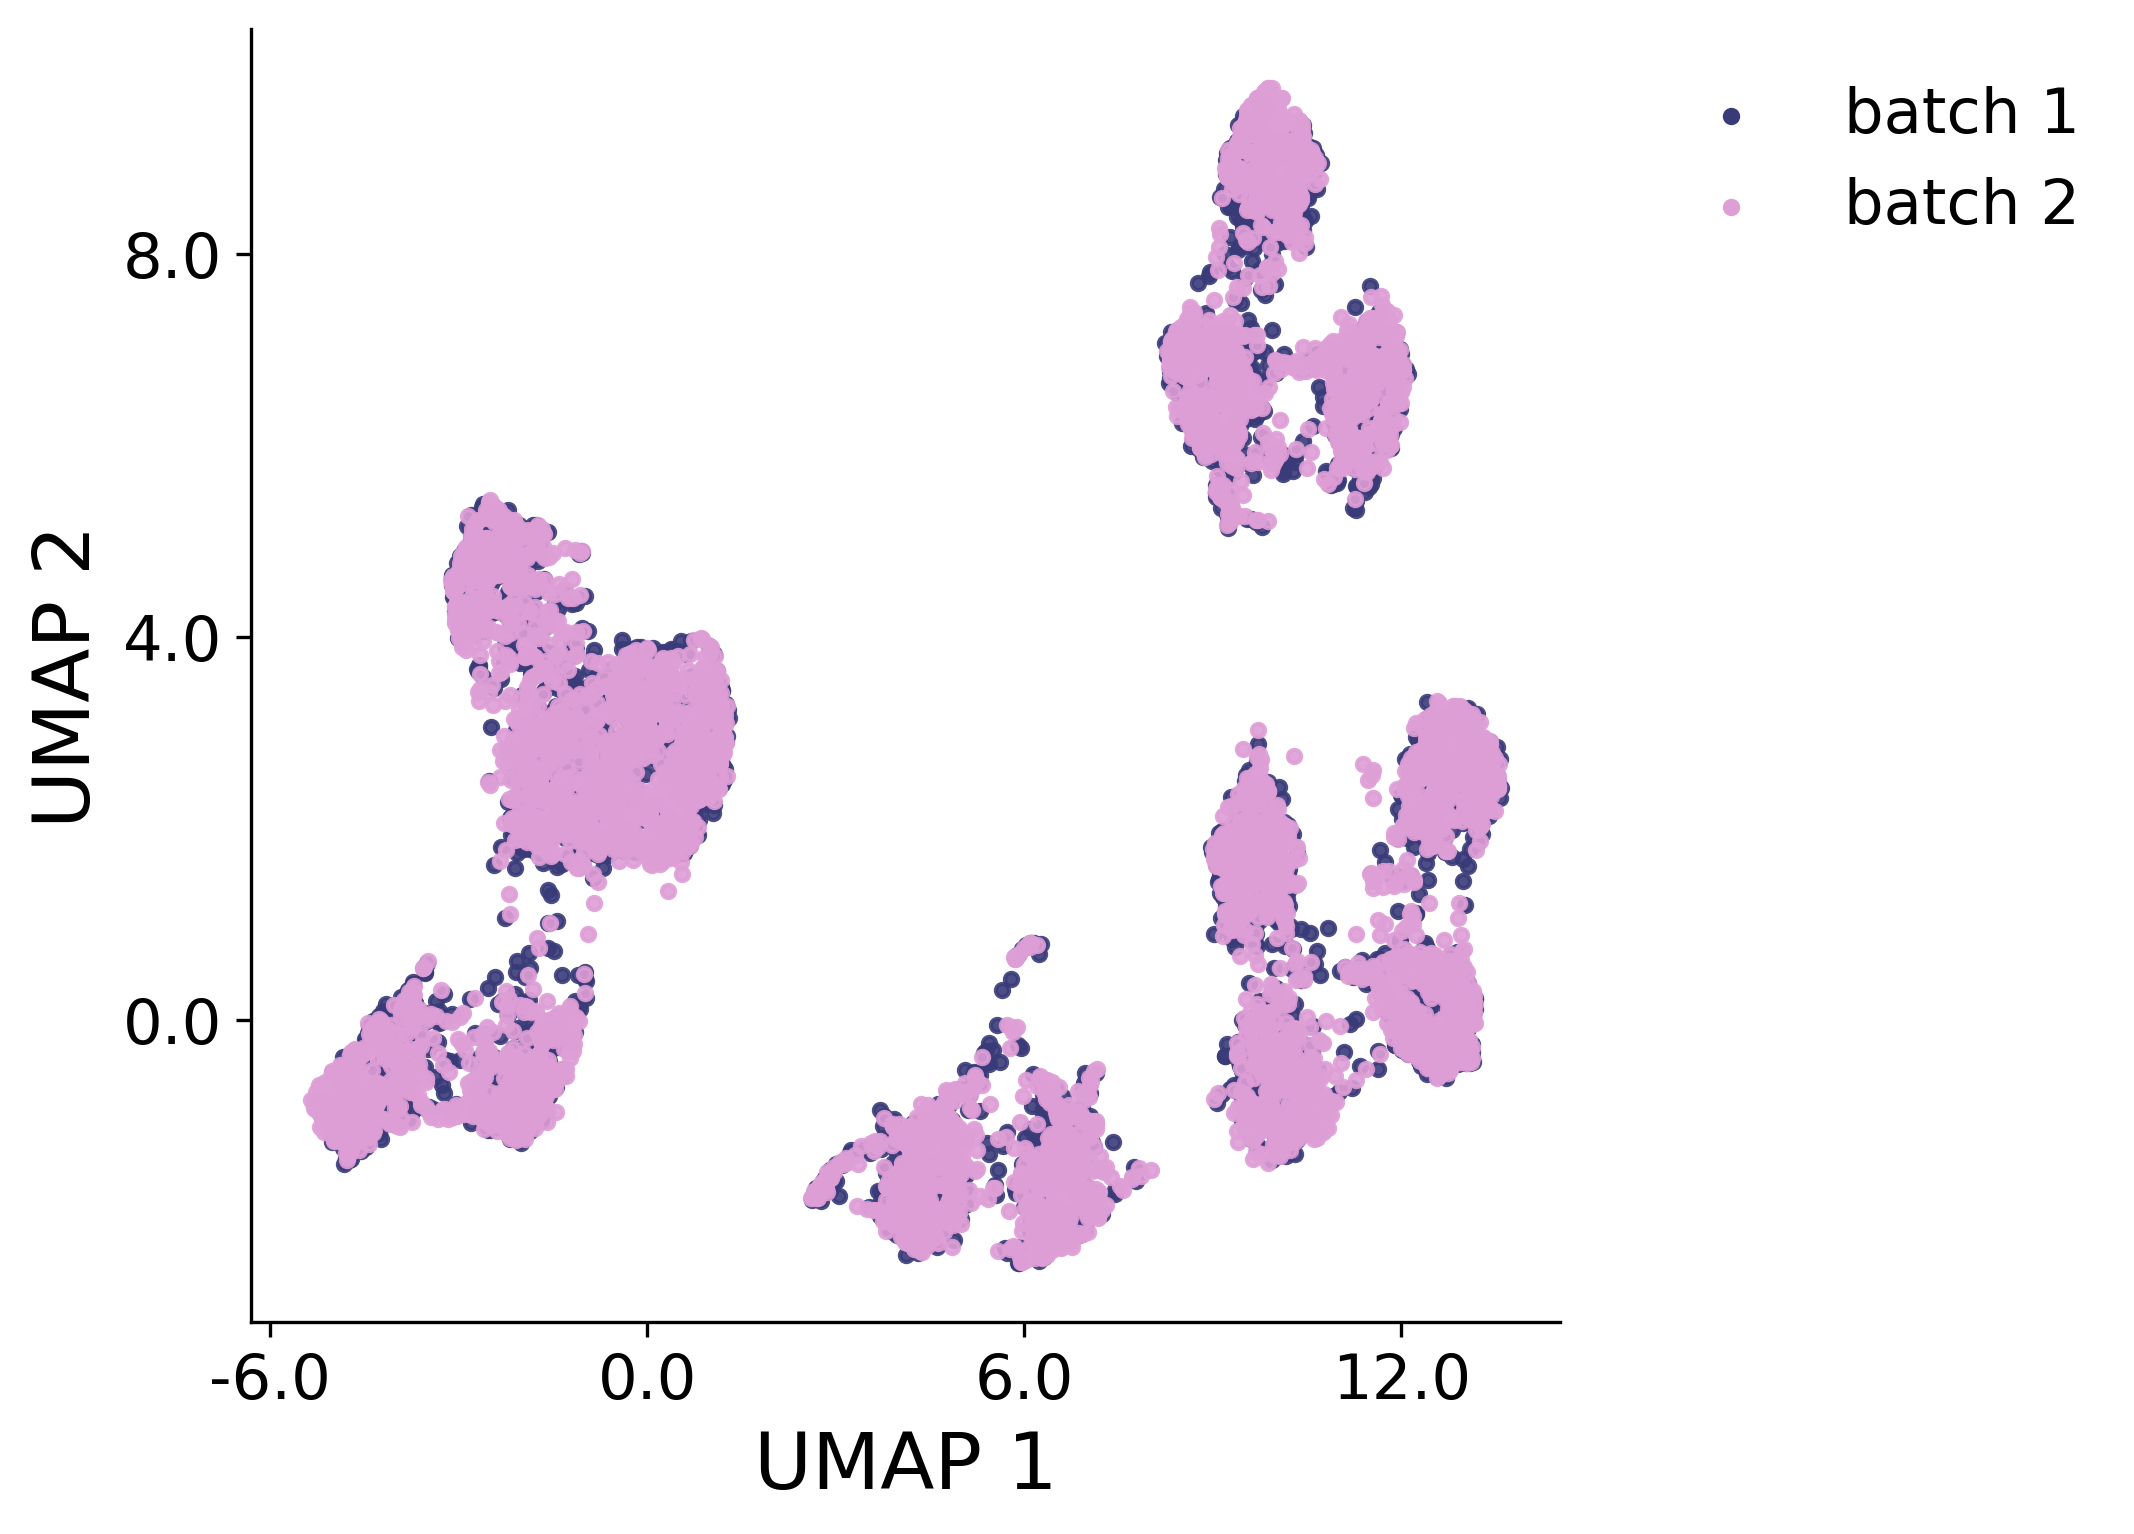

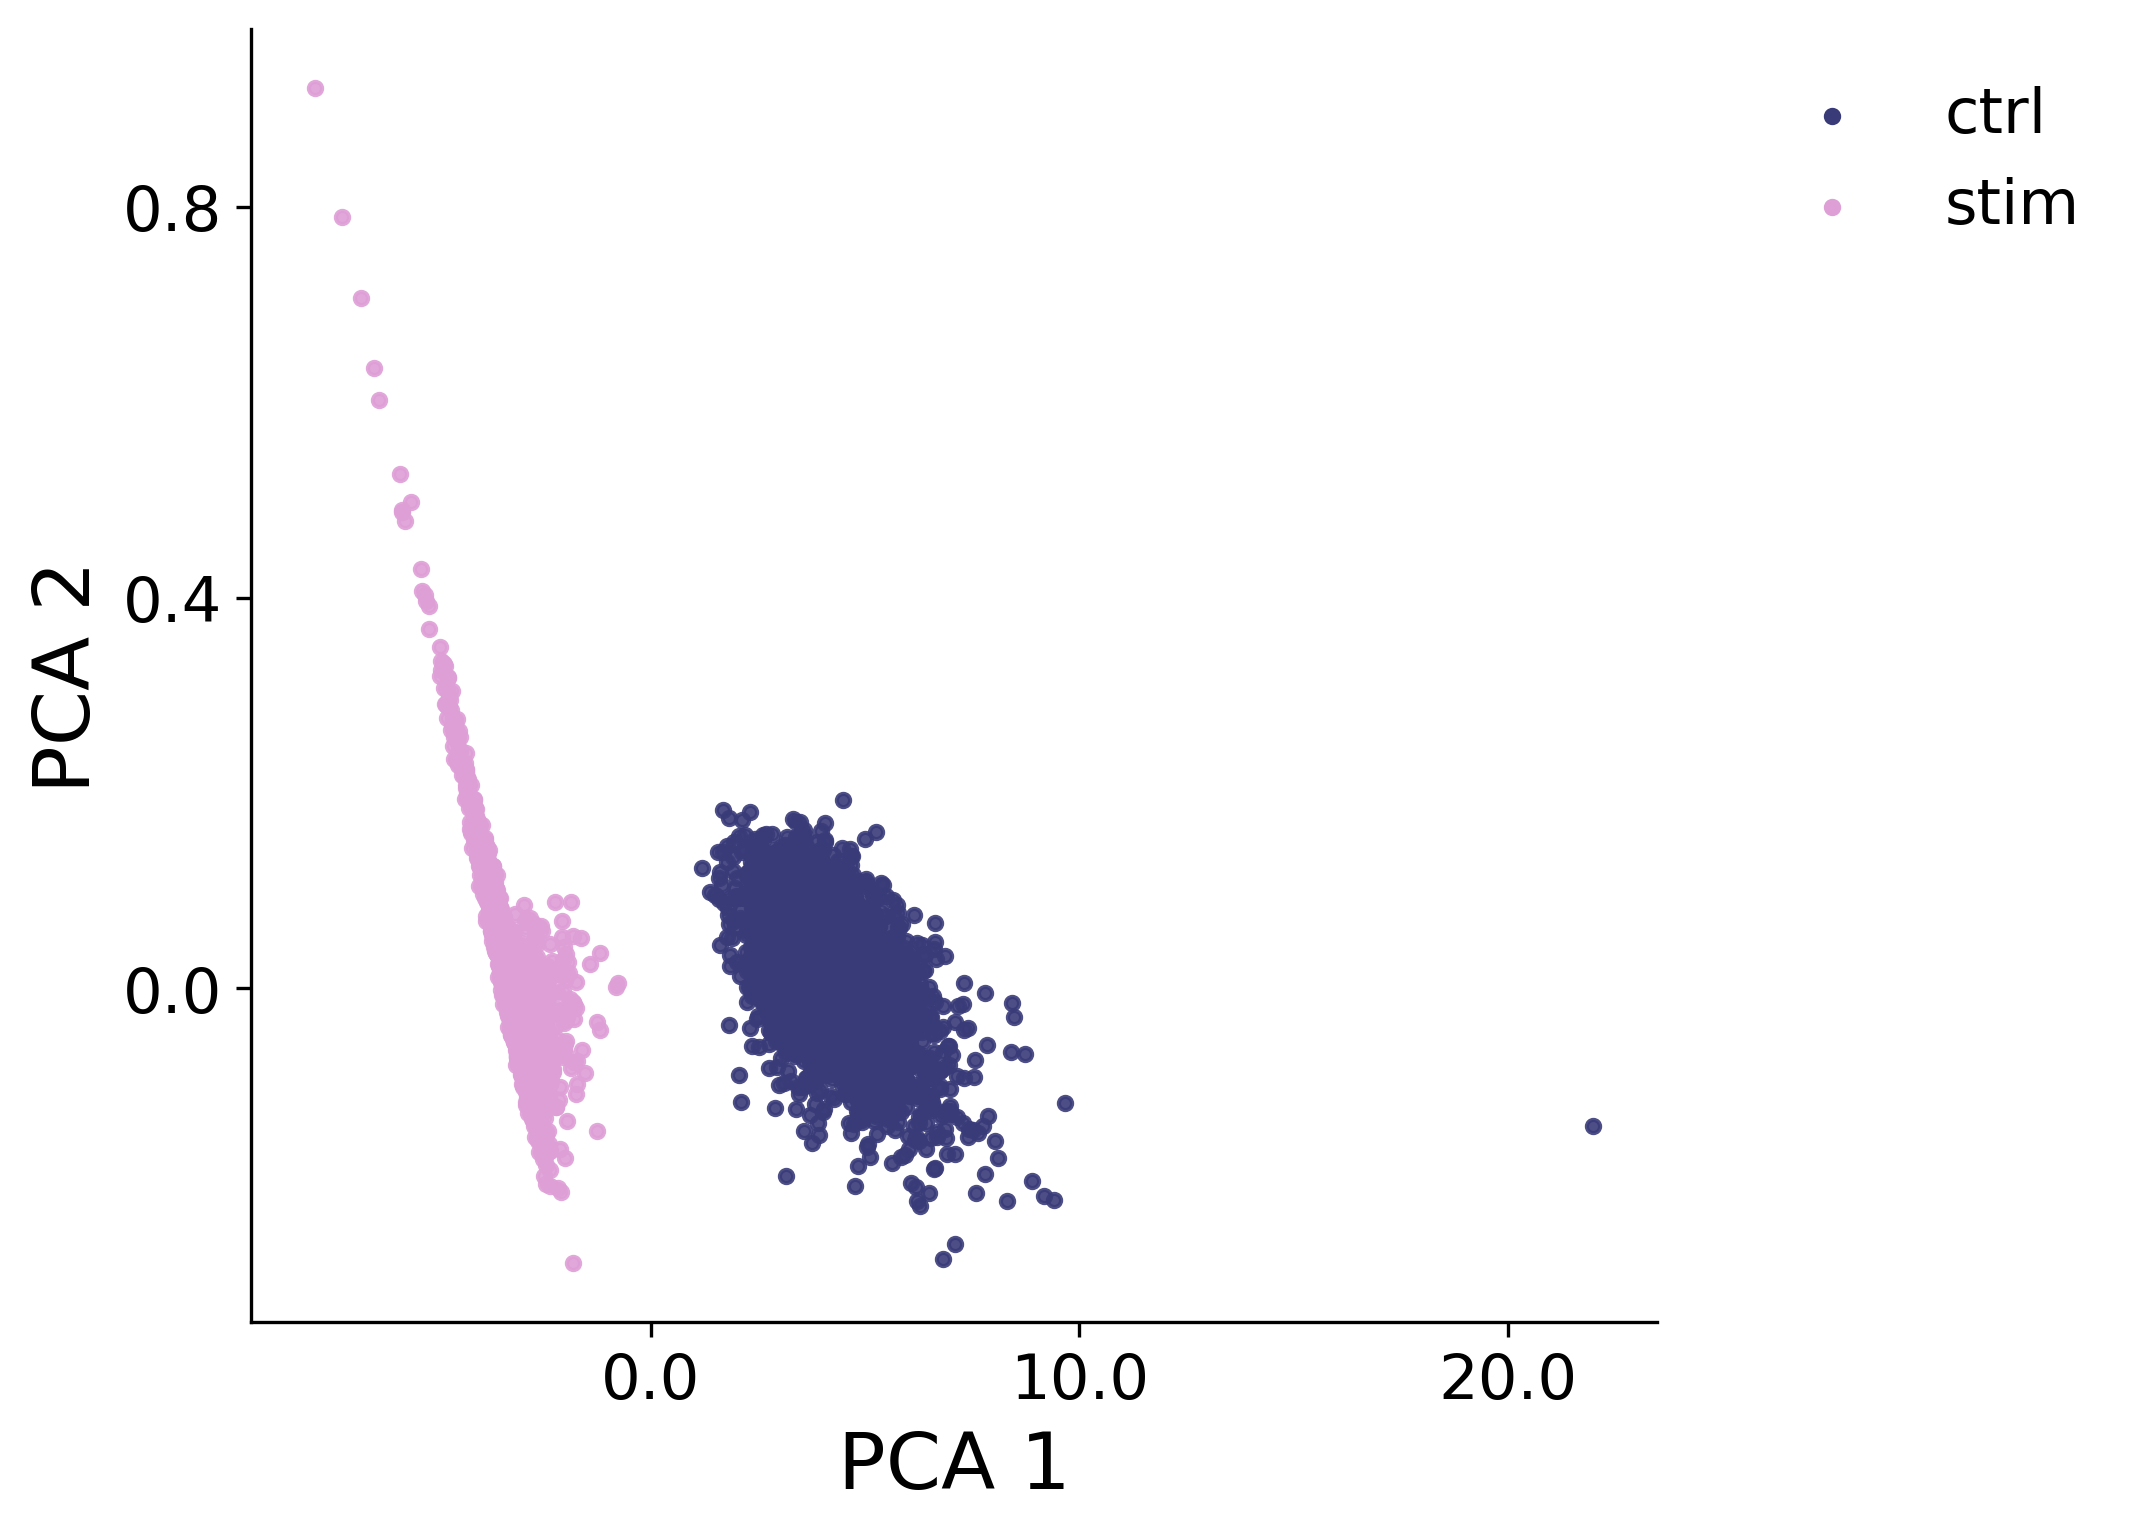

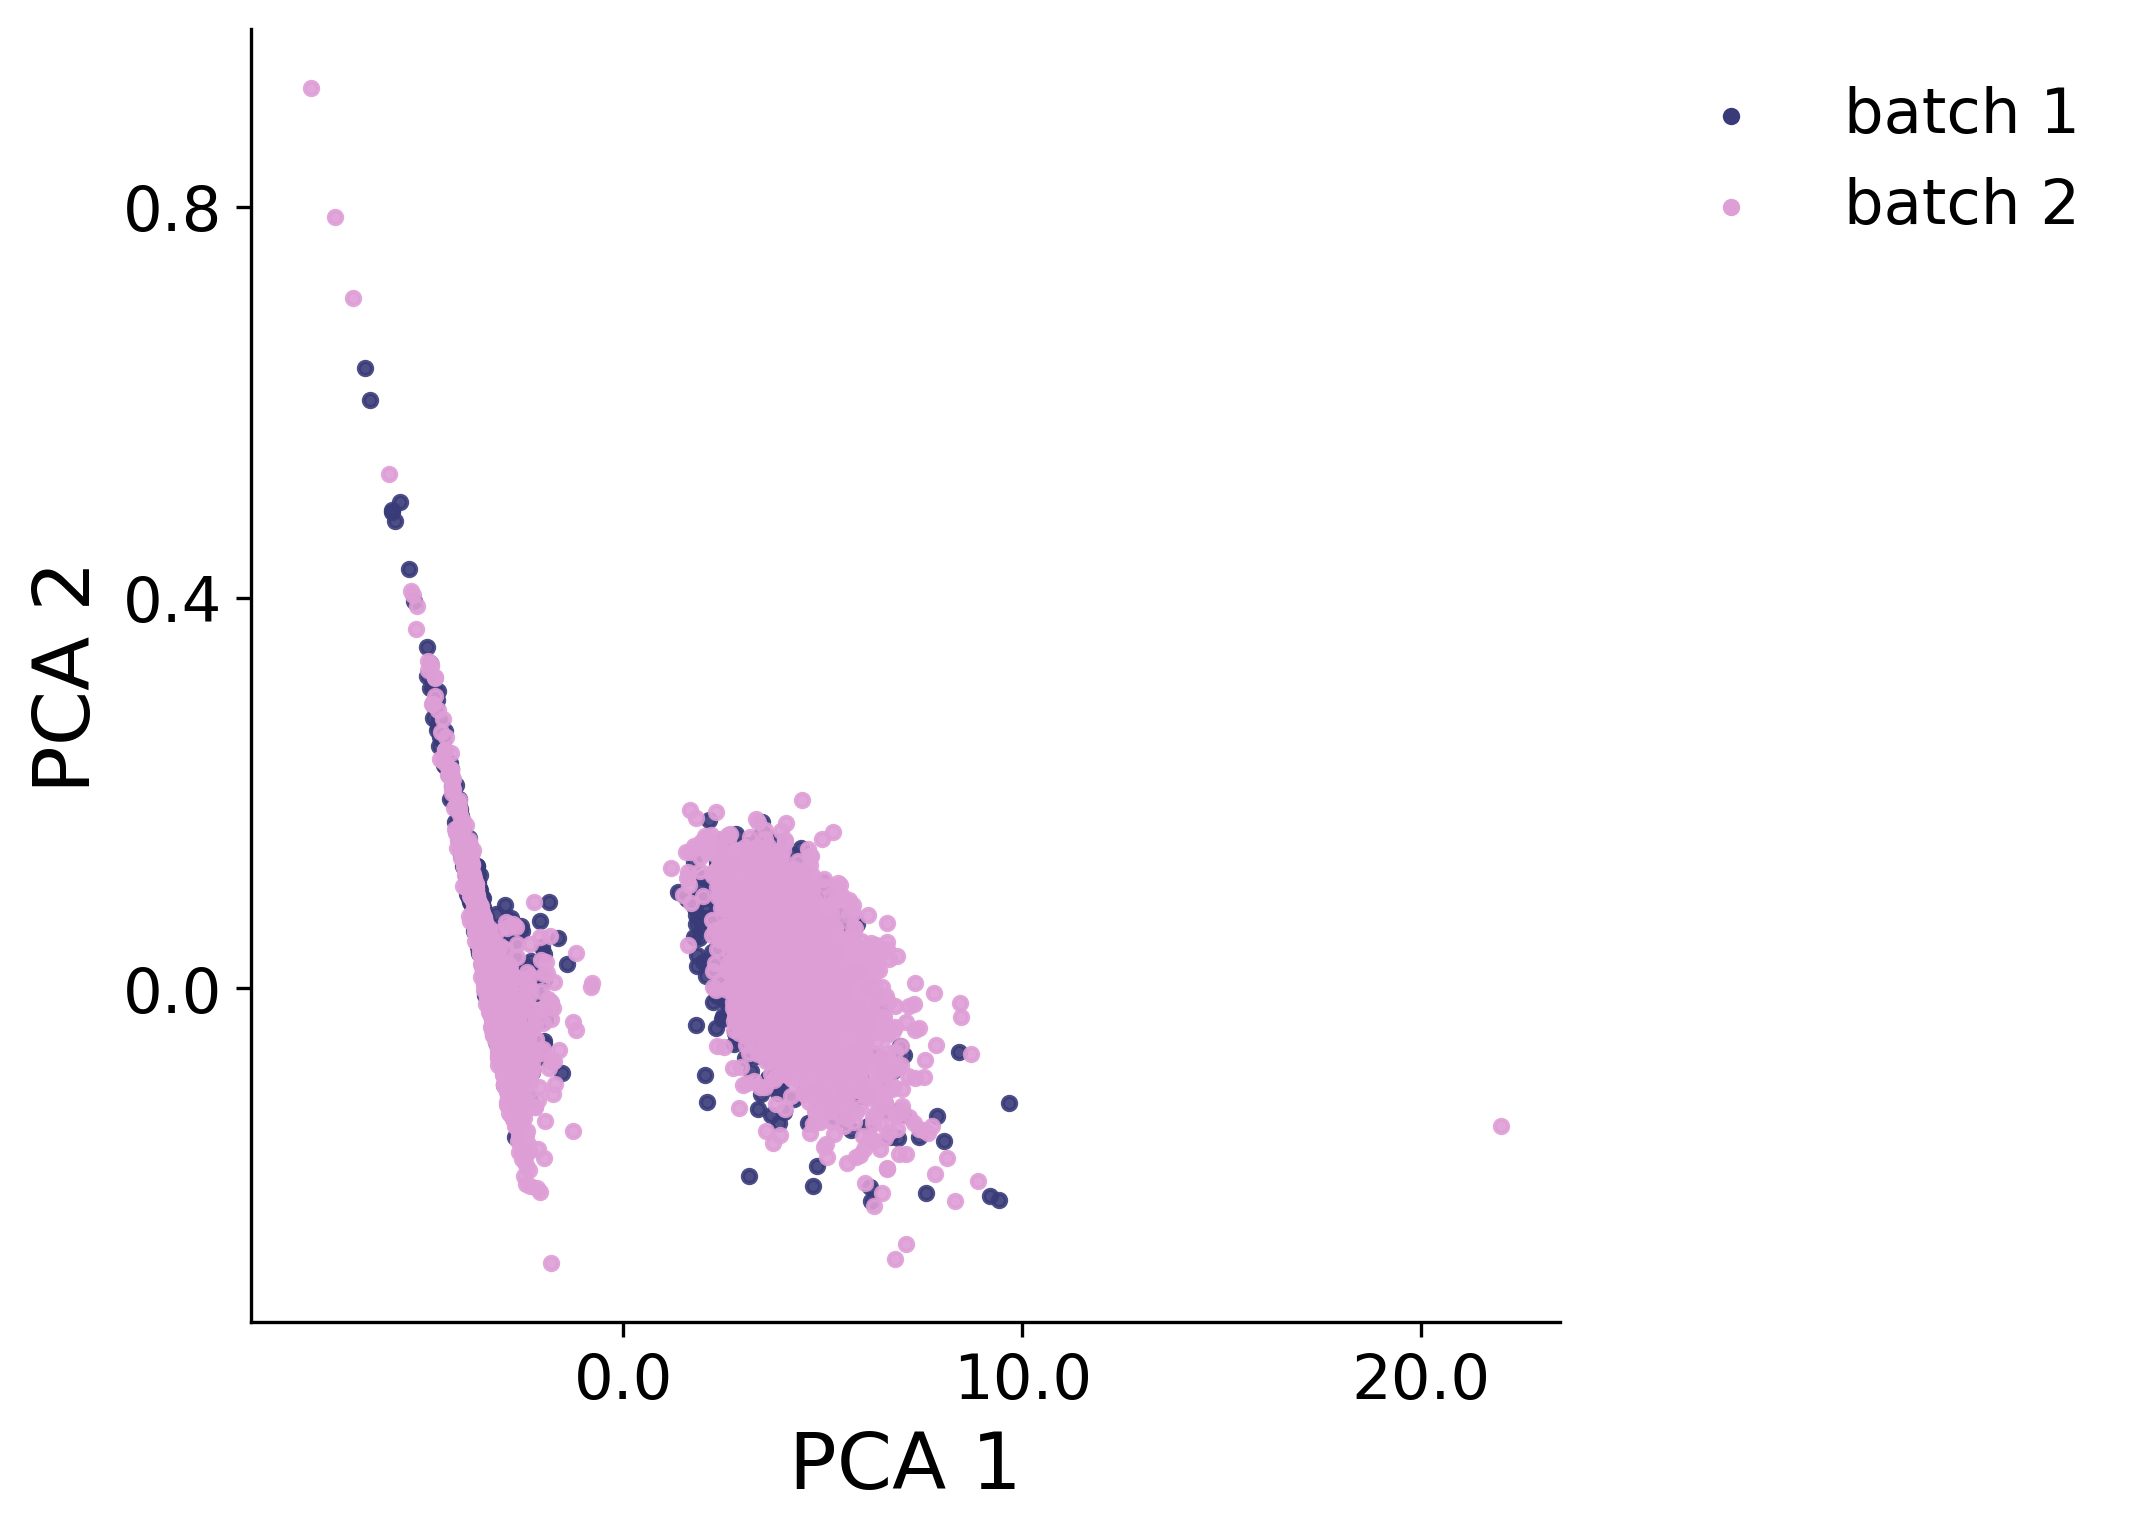

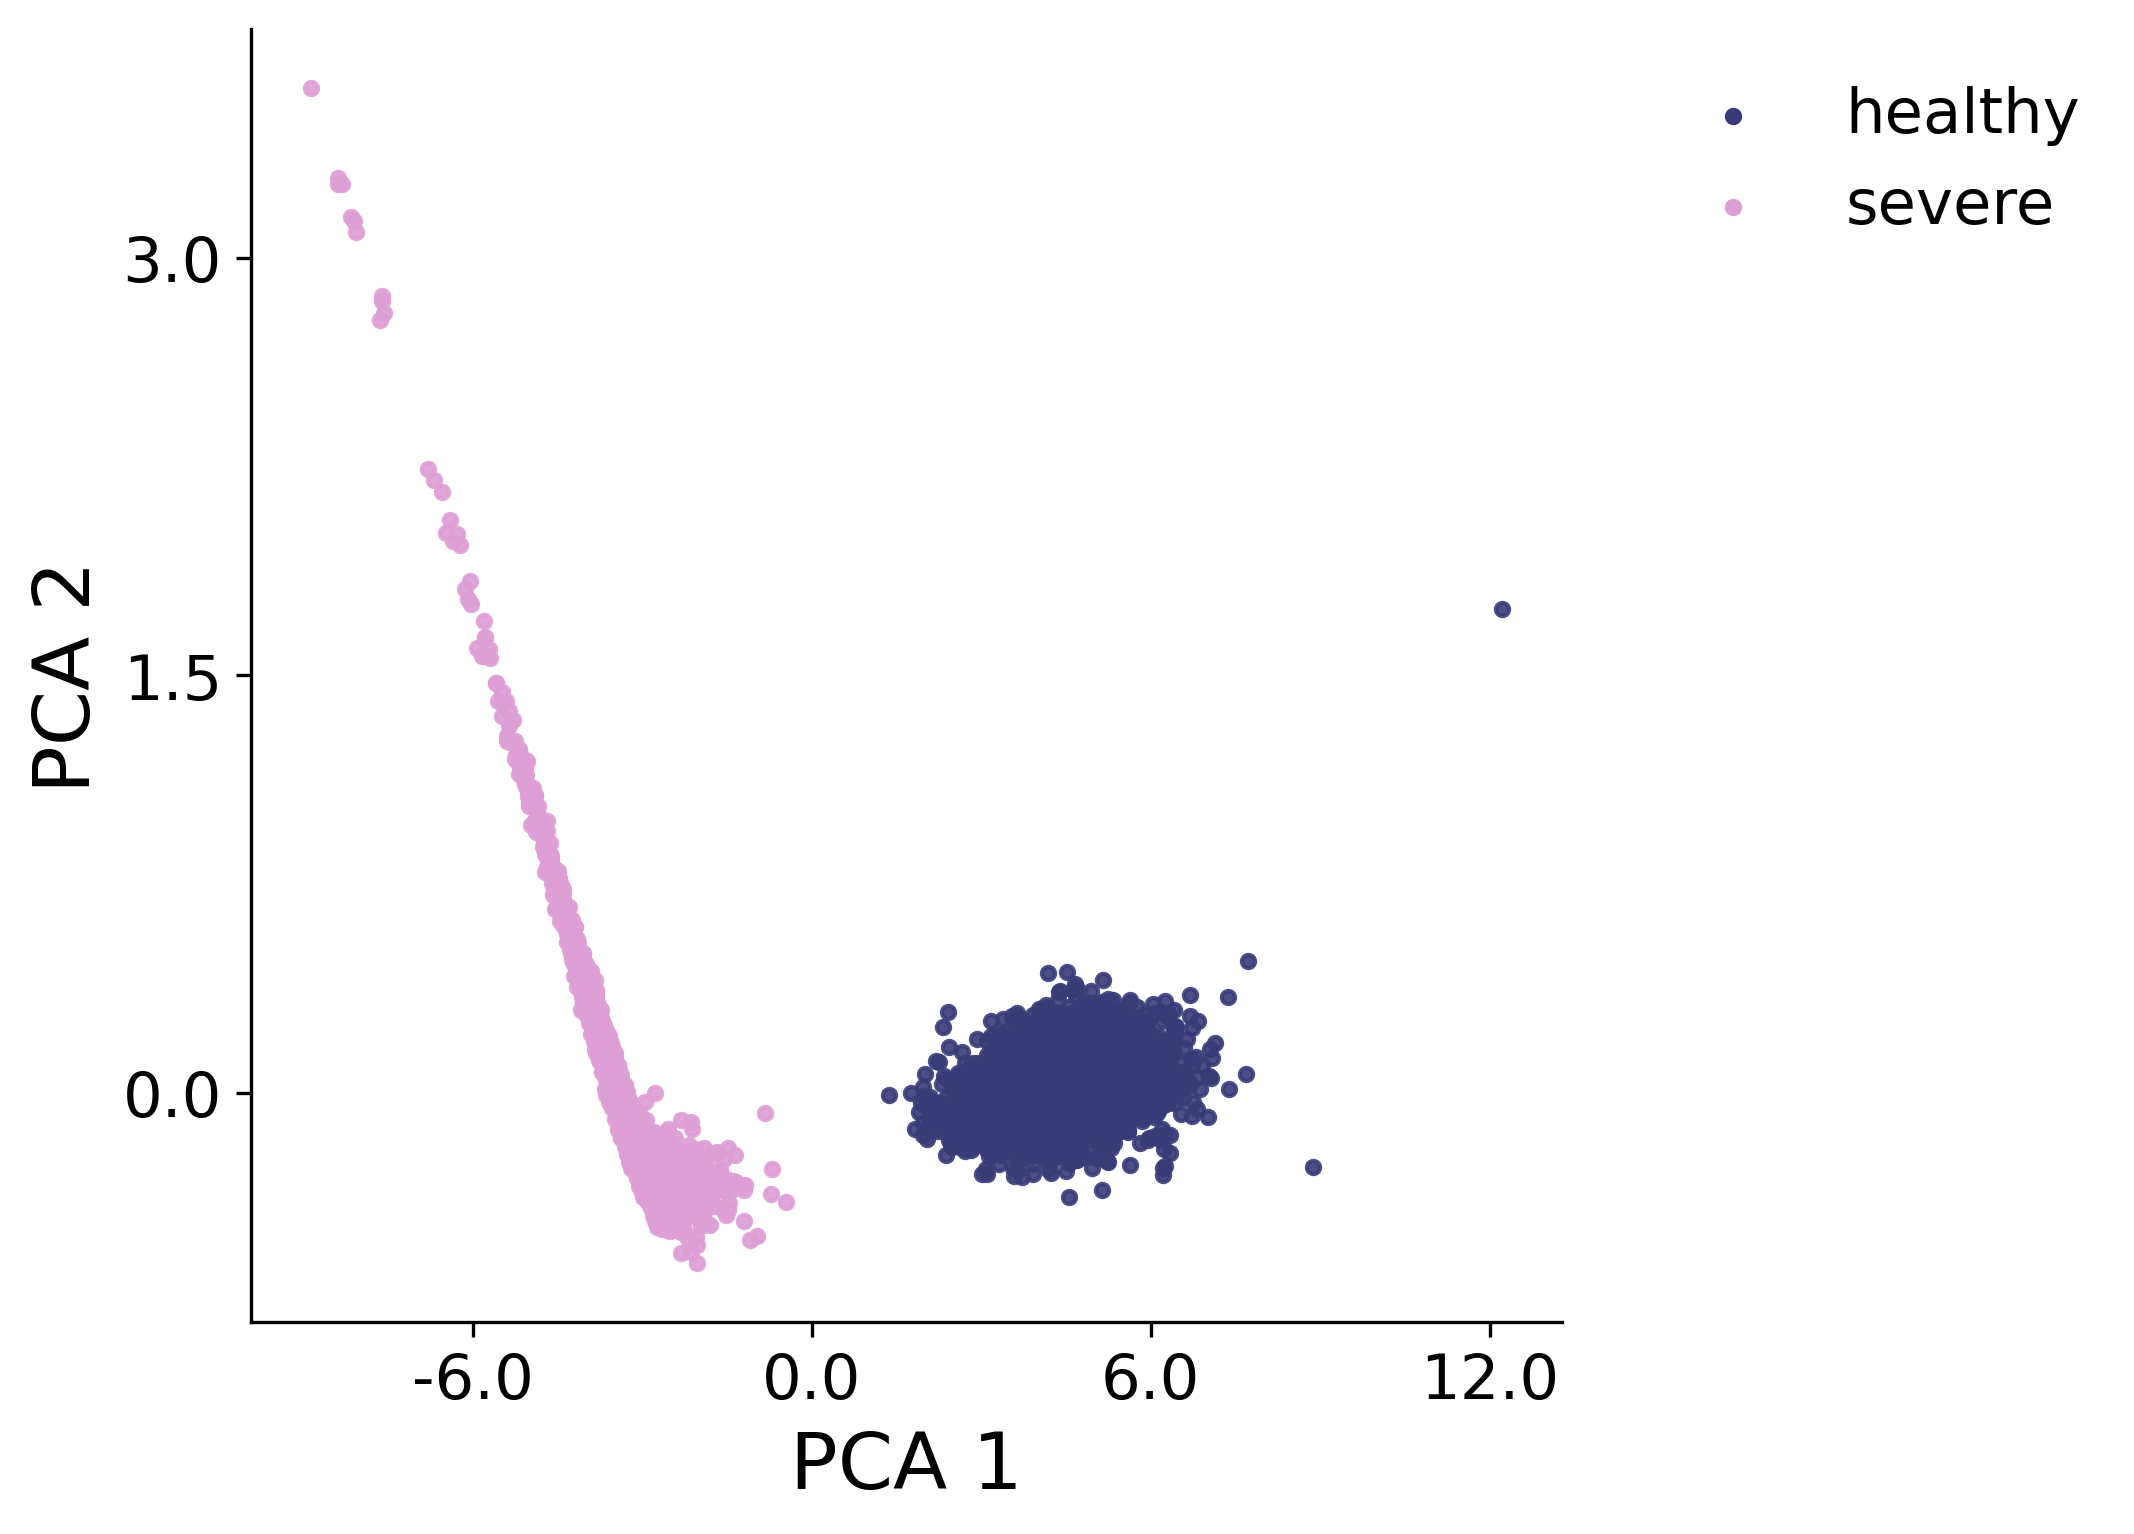

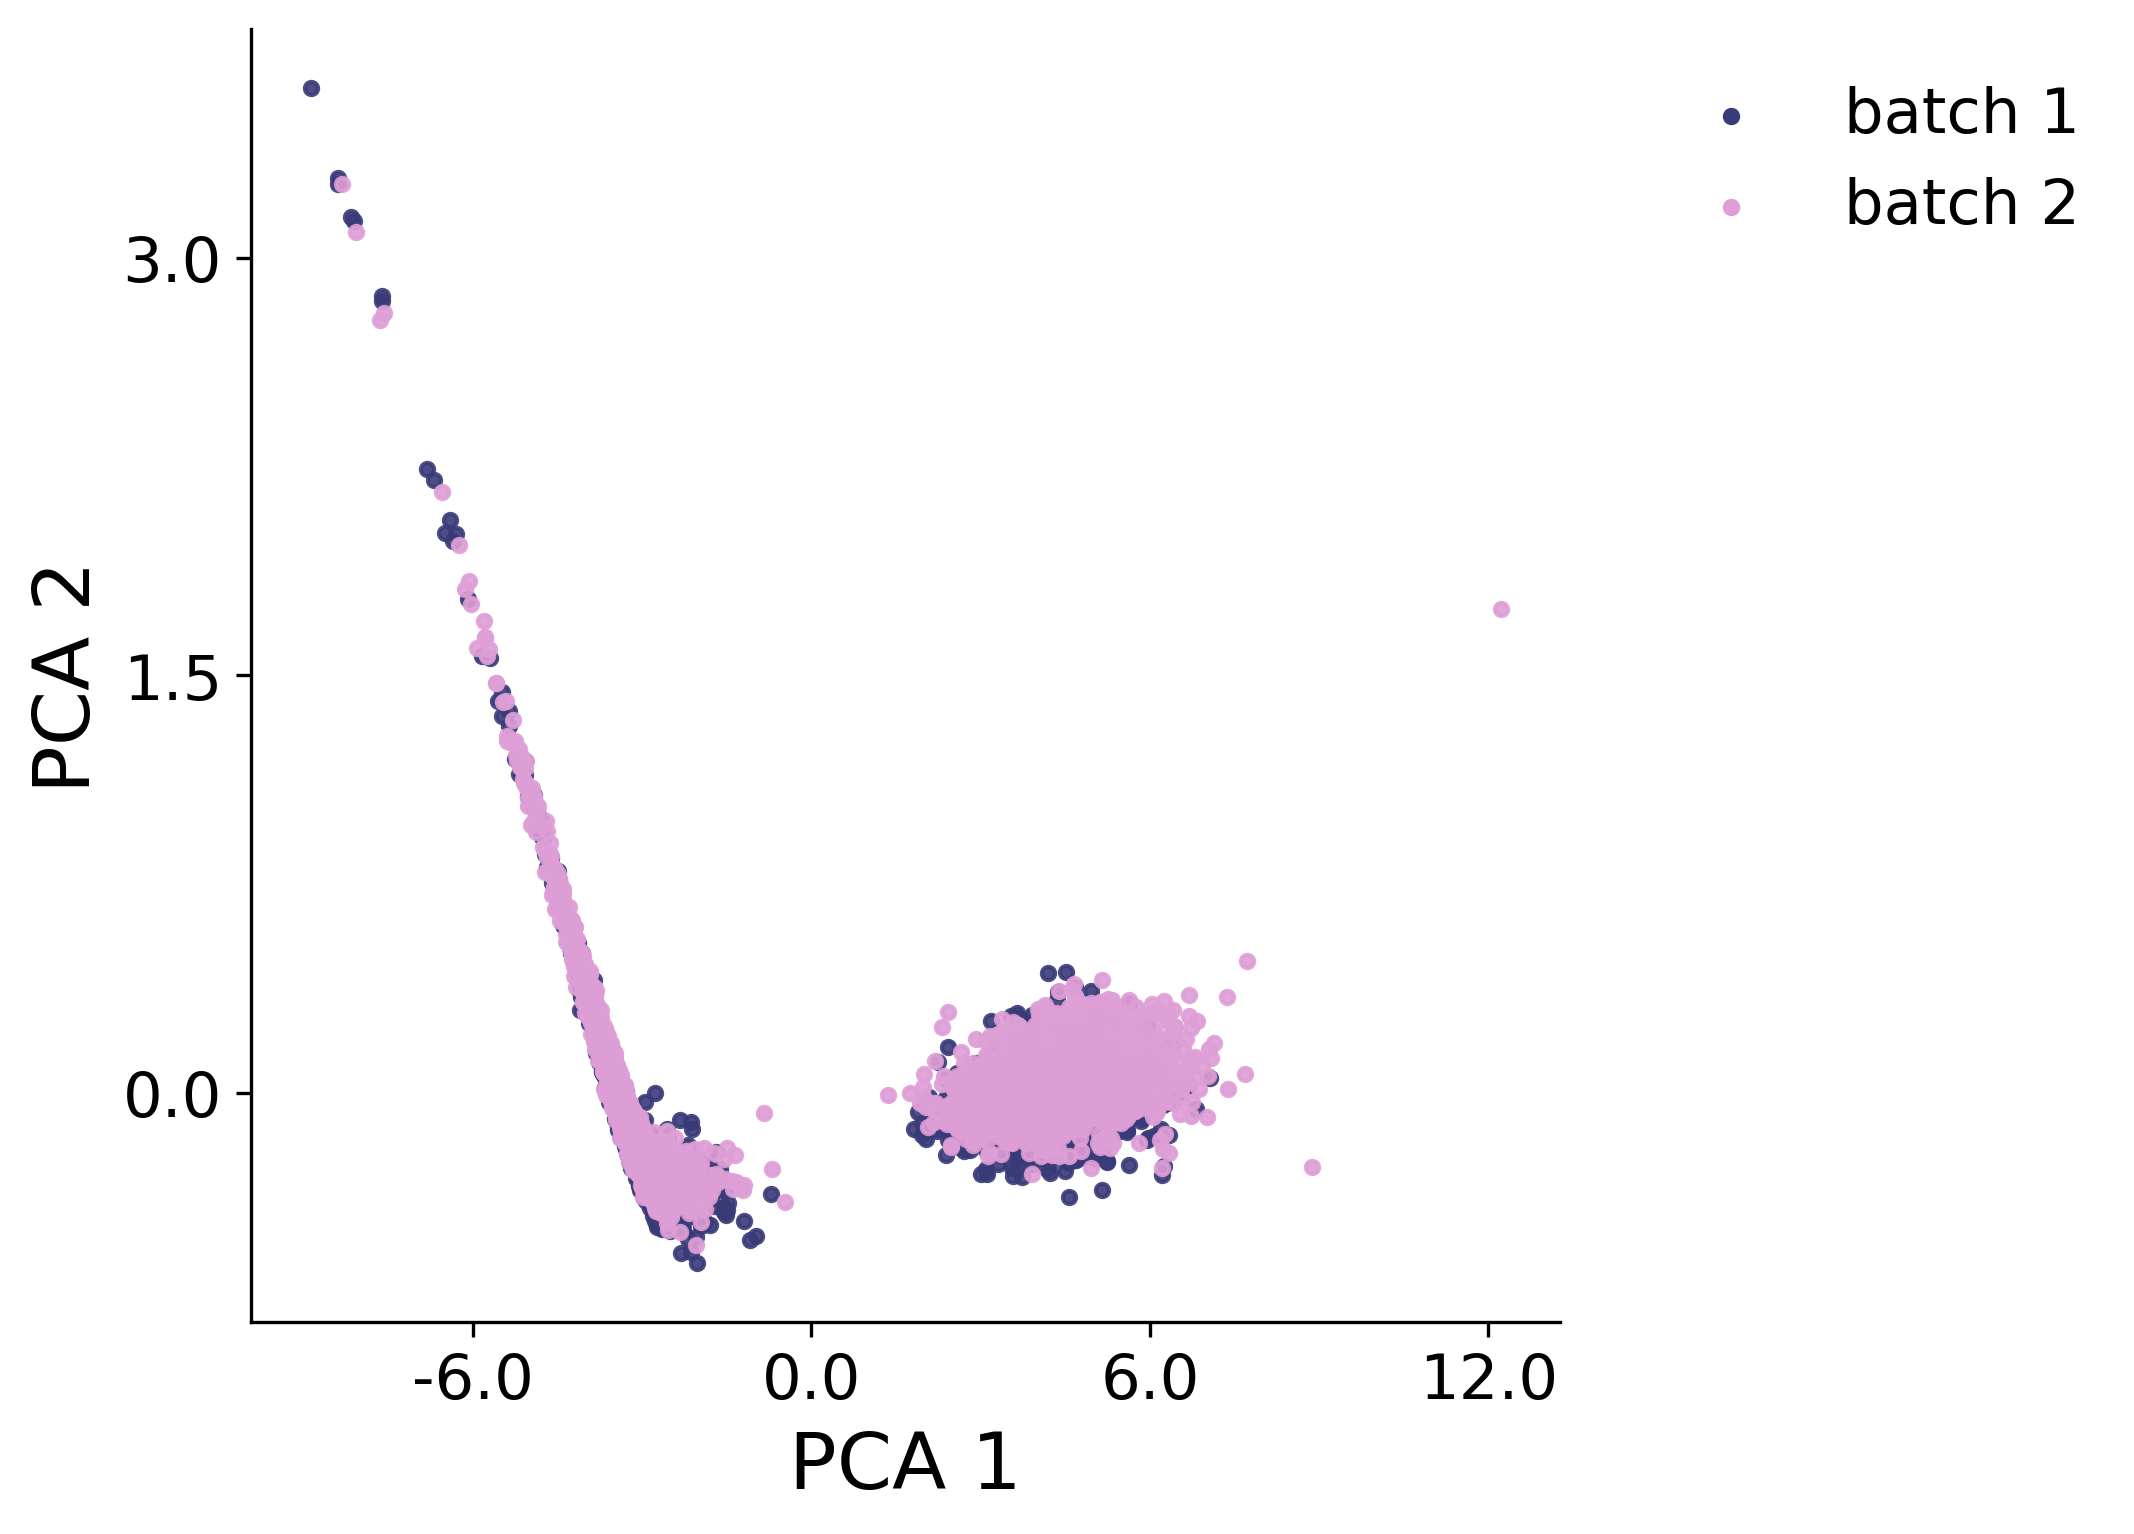

In [8]:
# UMAP
umap_op = UMAP(min_dist = 0.1, random_state = 0)
pca_op = PCA(n_components = 2)
z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
z_ds_umap = []
z_ds_umap.append(pca_op.fit_transform(np.concatenate([z_d[0] for z_d in z_ds], axis = 0)))
z_ds_umap.append(pca_op.fit_transform(np.concatenate([z_d[1] for z_d in z_ds], axis = 0)))

comment = f'results_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}/'
if not os.path.exists(result_dir + comment):
    os.makedirs(result_dir + comment)

batch_annos = np.concatenate([x["batch"].values.squeeze() for x in data_dict["meta_cells"]])
batch_annos = np.where(batch_annos == 0, "batch 1", "batch 2")
utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "UMAP", figsize = (10,5), save = result_dir + comment+"common_dims_annos.png")
# utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "separate", axis_label = "UMAP", figsize = (10,10), save = result_dir + comment+"common_dims_annos_separate.png")

utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "UMAP", figsize = (7,5), save = result_dir + comment+"common_dims_batches.png")
# utils.plot_latent(zs = z_cs_umap, annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "UMAP", figsize = (7,5), save = result_dir + comment+"common_dims_cond1.png")

utils.plot_latent(zs = z_ds_umap[0], annos = np.concatenate([x["condition 1"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims1_cond1.png")
utils.plot_latent(zs = z_ds_umap[0], annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims1_batches.png")

utils.plot_latent(zs = z_ds_umap[1], annos = np.concatenate([x["condition 2"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "annos", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims2_cond1.png")
utils.plot_latent(zs = z_ds_umap[1], annos = np.concatenate([x["annos"].values.squeeze() for x in data_dict["meta_cells"]]), batches = batch_annos, mode = "batches", axis_label = "PCA", figsize = (7,5), save = result_dir + comment+"diff_dims2_batches.png")


## Key gene extraction

The condition-associated gene scores can be extracted with `model.extract_gene_scores()`. The function returns a list with length equal to the total number of condition types. The $i$th element is the scores of genes (a `np.array`) under that condition type, the order of the scores matches the input genes. 

In [9]:
gene_scores = model.extract_gene_scores()
# the scores of 500 genes for condition type 1
print(gene_scores[0])
# the scores of 500 genes for condition type 2
print(gene_scores[1])


[1.63669419e-02 9.14421678e-03 1.03906989e-02 2.44847834e-02
 1.10281147e-02 5.04428595e-02 1.99805293e-02 2.87926253e-02
 2.26134062e-02 1.68385115e-02 1.64539106e-02 1.54288597e-02
 1.02815181e-02 1.06106382e-02 1.03216600e-02 2.21145283e-02
 1.20886862e-02 2.03598756e-02 9.06910188e-03 1.94463022e-02
 1.00129182e-02 2.09469944e-02 1.98464487e-02 1.67217739e-02
 9.54557024e-03 1.64563600e-02 1.14200022e-02 1.05871251e-02
 1.11636473e-02 1.32796932e-02 1.70270558e-02 2.98575647e-02
 1.59699973e-02 1.27448607e-02 9.04416014e-03 9.79706272e-03
 9.50883888e-03 3.32097337e-02 1.66252516e-02 1.65118147e-02
 1.34429010e-02 1.88532658e-02 1.07760923e-02 1.86592601e-02
 1.01714404e-02 2.33502220e-02 2.26591676e-02 1.37888743e-02
 1.82681791e-02 1.05414847e-02 1.22234732e-01 1.70774072e-01
 1.29416421e-01 6.95167482e-02 6.00959137e-02 1.07012443e-01
 6.50875494e-02 8.51563737e-02 5.50793707e-02 2.30056405e-01
 9.14855376e-02 5.90917945e-01 1.05939798e-01 5.47770932e-02
 2.53401399e-01 4.810522

## Prediction
Predict the count of the data under a different condition (and even remove the batch effect) with `model.predic_counts`. 
* `predict_dataset` takes as input a scDisInFact dataset that user wish to perform prediction on. 
* `predict_conds` take as input a list of predicting condition groups under each condition type.
* `predict_batch` take as input a value of the batch that the predicted count should be matched to.



Given the test matrix under `(stim, severe, batch 1)`, and we wish to predict the corresponding count matrix under `(ctrl, healthy, batch 0)`. We need to run

In [10]:
input_idx = ((meta_cells["condition 1"] == "stim") & (meta_cells["condition 2"] == "severe") & (meta_cells["batch"] == 1)).values
counts_input = counts[input_idx,:].toarray()
meta_input = meta_cells.loc[input_idx,:]

counts_predict = model.predict_counts(input_counts = counts_input, meta_cells = meta_input, condition_keys = ["condition 1", "condition 2"], 
                                      batch_key = "batch", predict_conds = ["ctrl", "healthy"], predict_batch = 0)


We can also denoise the count matrix under `(ctrl, healthy, batch 0)` by setting the `predict_conds` and `predict_batch` to be `None`

In [11]:
test_idx = ((meta_cells["condition 1"] == "ctrl") & (meta_cells["condition 2"] == "healthy") & (meta_cells["batch"] == 0)).values
counts_test = counts[test_idx,:].toarray()
meta_test = meta_cells.loc[test_idx,:]

counts_test_denoised = model.predict_counts(input_counts = counts_test, meta_cells = meta_test, condition_keys = ["condition 1", "condition 2"], 
                                            batch_key = "batch", predict_conds = None, predict_batch = None)

Visualize the predicted counts and the denoised test count. Since condition and batch are aligned between predicted and test count, the gene expression should be also aligned

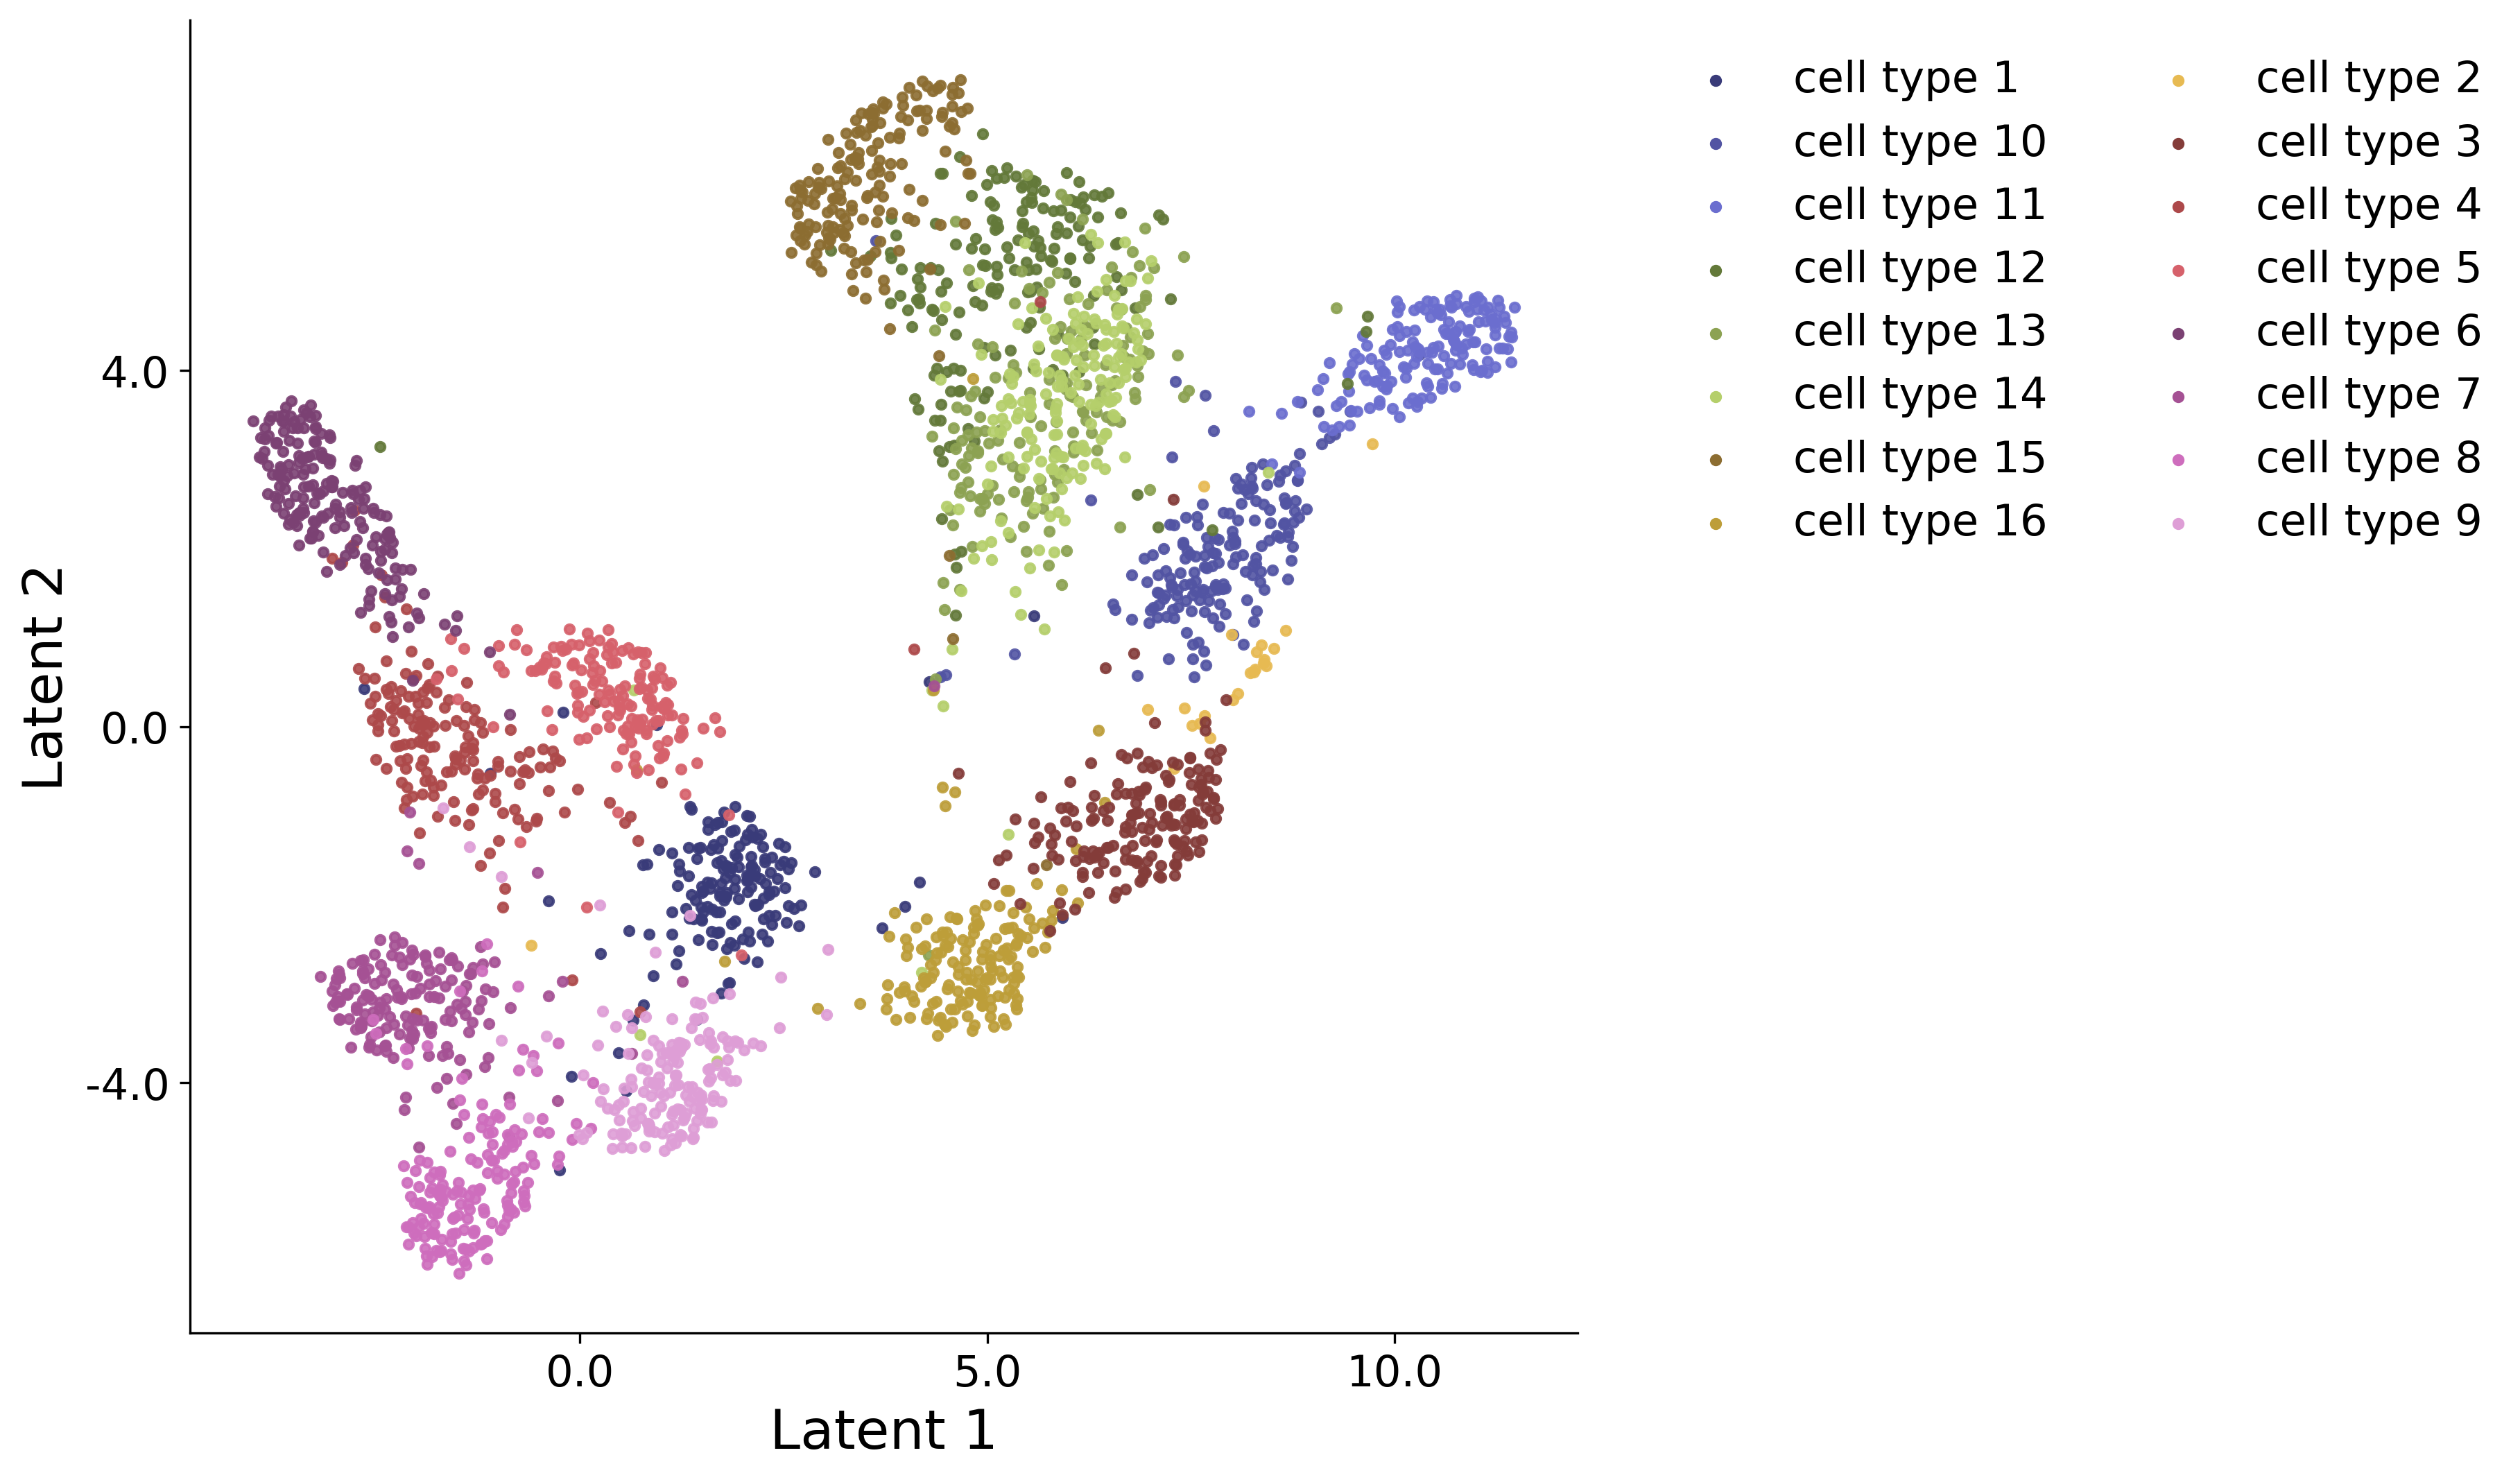

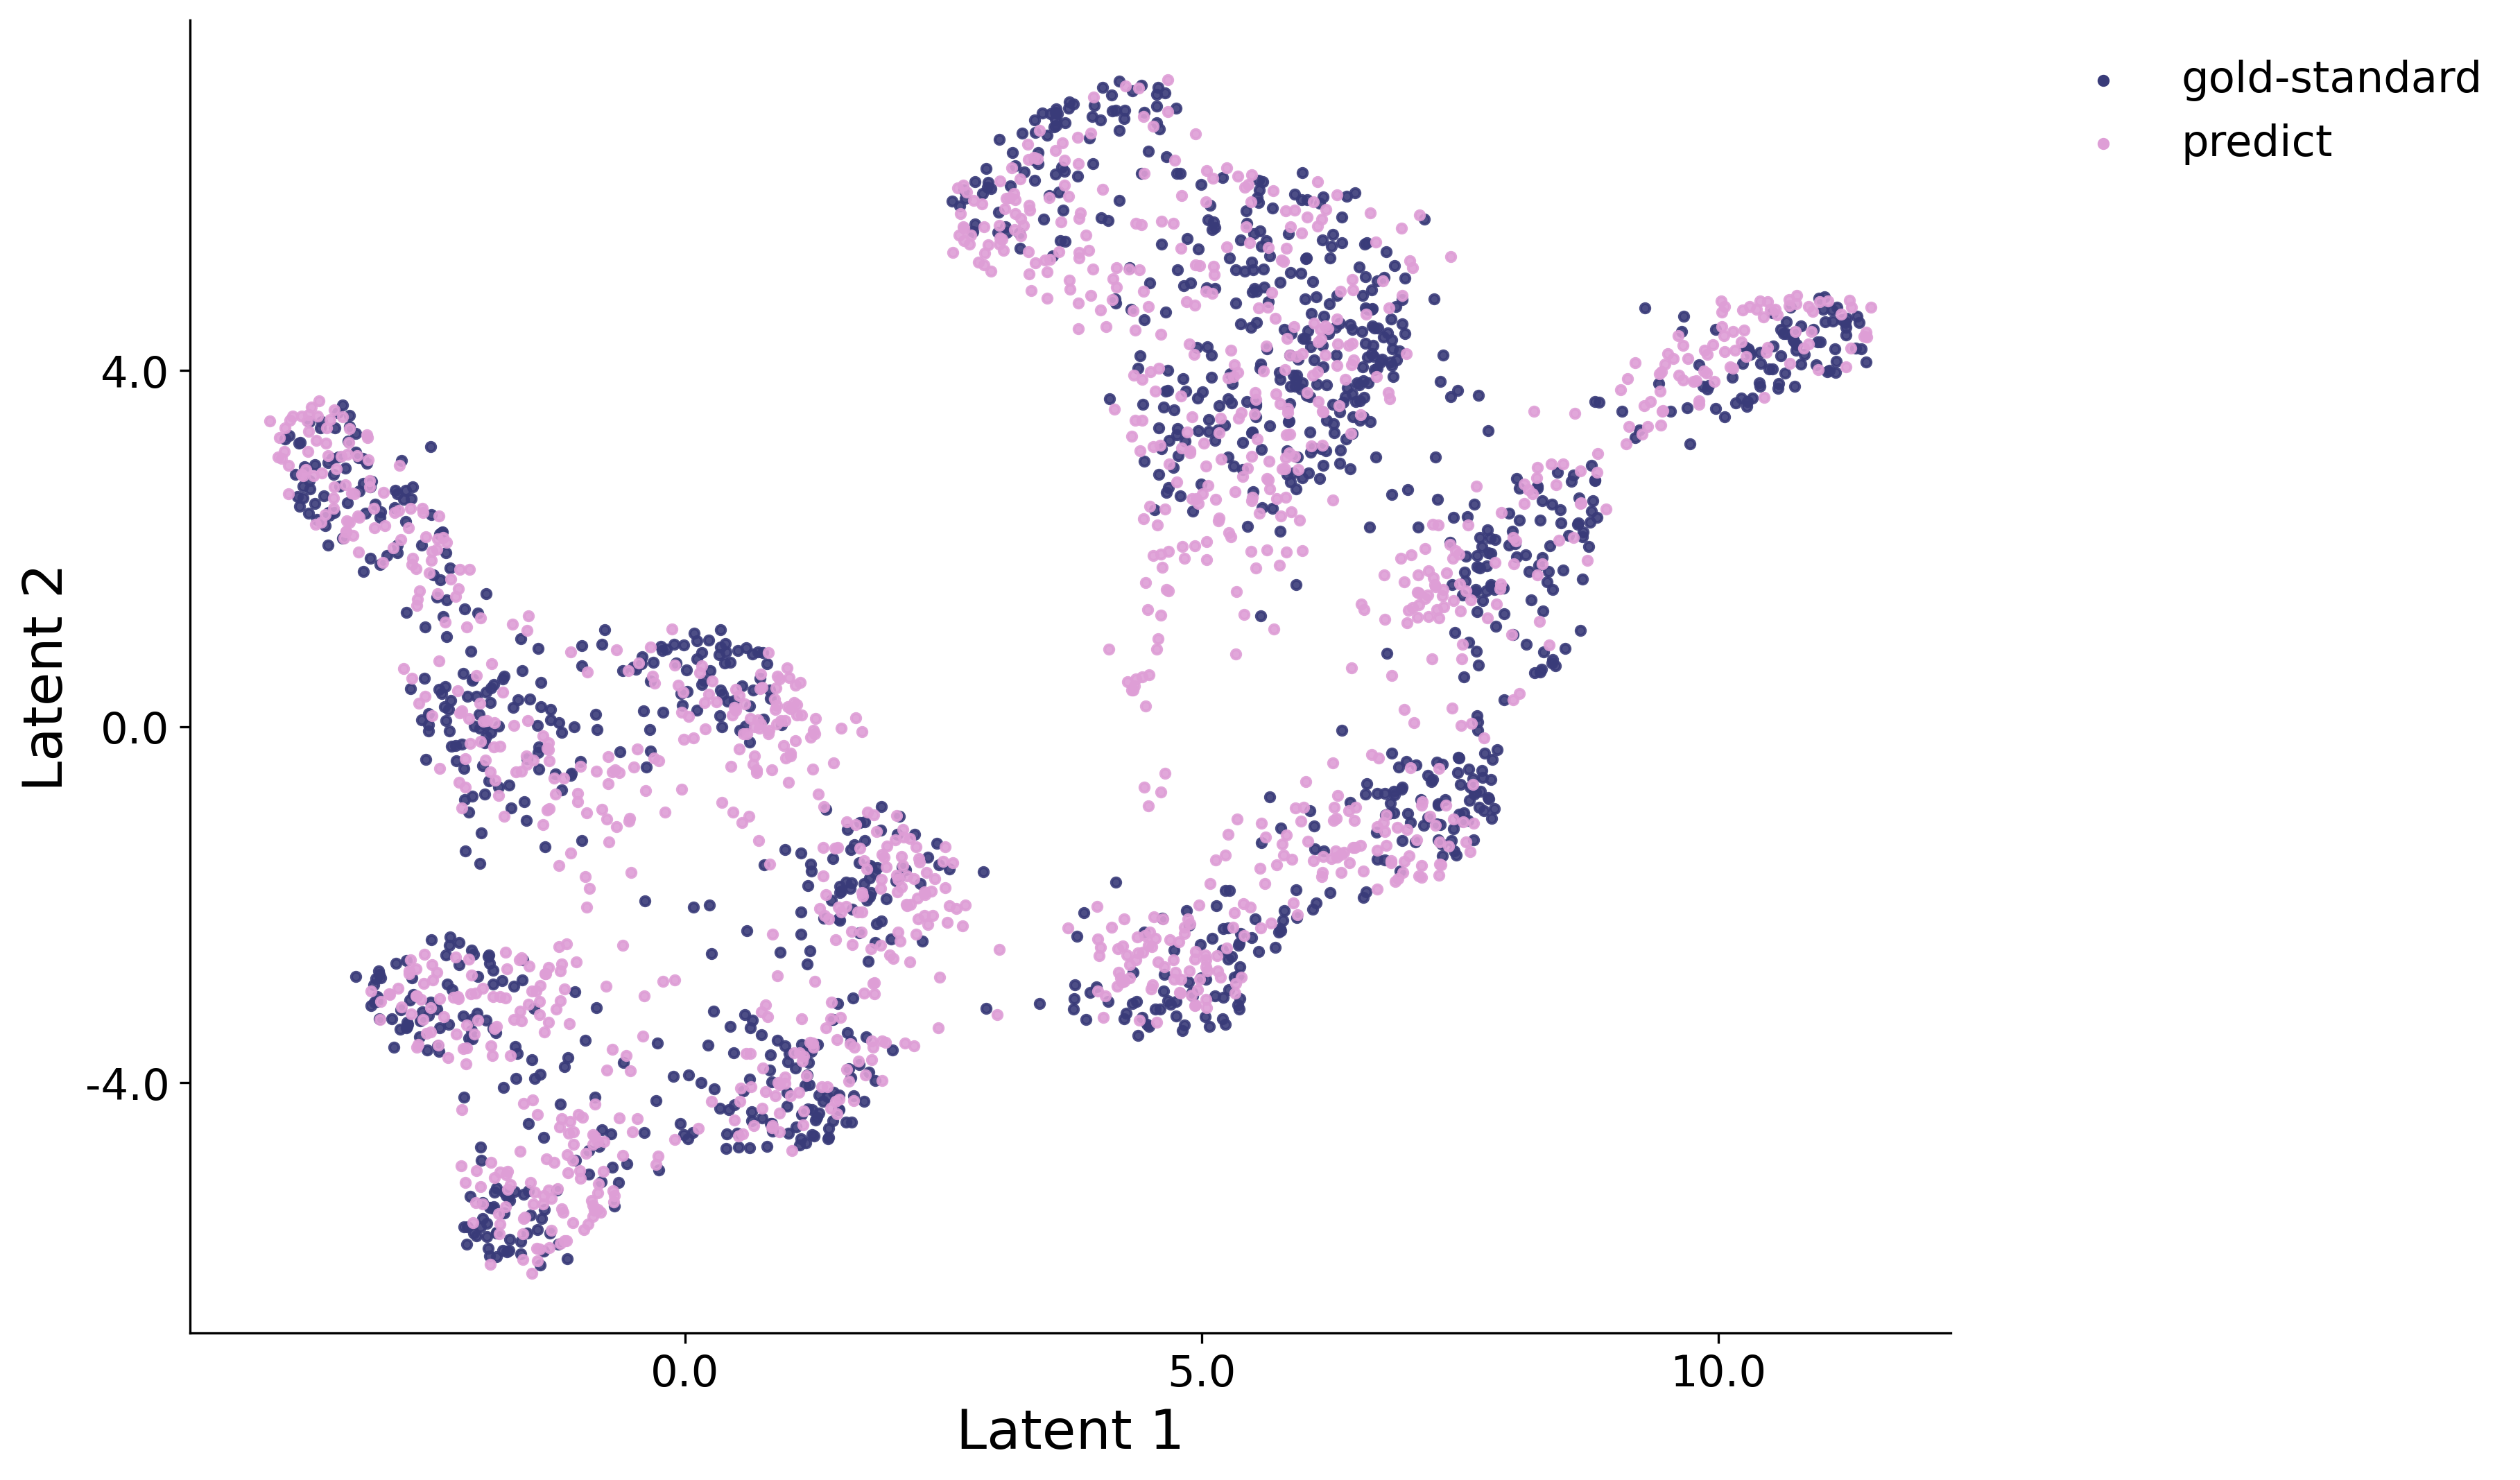

In [12]:
counts_predict_norm = counts_predict/(np.sum(counts_predict, axis = 1, keepdims = True) + 1e-6) * 100
counts_predict_norm = np.log1p(counts_predict_norm)
counts_test_norm = counts_test_denoised/(np.sum(counts_test_denoised, axis = 1, keepdims = True) + 1e-6) * 100
counts_test_norm = np.log1p(counts_test_norm)
# plot umap
umap_op = UMAP(n_components = 2, n_neighbors = 100, min_dist = 0.4, random_state = 0) 
x_umap_scdisinfact = umap_op.fit_transform(np.concatenate([counts_predict_norm, counts_test_norm], axis = 0))

utils.plot_latent(x_umap_scdisinfact, annos = np.concatenate([meta_input["annos"].values, meta_test["annos"].values], axis = 0), batches = np.array(["predict"] * counts_predict.shape[0] + ["gold-standard"] * counts_test.shape[0]), \
    mode = "annos", save = result_dir + comment + "predict_batches.png", figsize = (12,7))
utils.plot_latent(x_umap_scdisinfact, annos = np.concatenate([meta_input["annos"].values, meta_test["annos"].values], axis = 0), batches = np.array(["predict"] * counts_predict.shape[0] + ["gold-standard"] * counts_test.shape[0]), \
    mode = "batches", save = result_dir + comment + "predict_batches.png", figsize = (12,7))